In [1]:
import numpy as np
from numpy import array
from numpy import savetxt
import math
from scipy.fft import dct
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import IPython.display as ipd
import librosa
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pathlib

### Carga Audios

In [3]:
#Parámetros
sampling_rate = 4096
duration = 2

#Calcula número de muestras
num_muestras = sampling_rate*duration
num_muestras

#Vector de clases
clases_vec = [0,1]
emotion_vec = ["Other","Angry"]

In [4]:
#Carga Audios Entrenamiento (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
trainAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/train'
#Carpeta con los audios de felicidad (Happy)
trainAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/train'
#Carpeta con los audios neutrales (Neutral)
trainAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/train'
#Carpeta con los audios de tristeza (Sad)
trainAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/train'
#Carpeta con los audios de tristeza (Surprise)
trainAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/train'
#Carga Audios Prueba (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
testAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/test'
#Carpeta con los audios de felicidad (Happy)
testAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/test'
#Carpeta con los audios neutrales (Neutral)
testAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/test'
#Carpeta con los audios de tristeza (Sad)
testAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/test'
#Carpeta con los audios de tristeza (Surprise)
testAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/test'
#Carga Audios Evaluación (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
evalAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/evaluation'
#Carpeta con los audios de felicidad (Happy)
evalAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/evaluation'
#Carpeta con los audios neutrales (Neutral)
evalAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/evaluation'
#Carpeta con los audios de tristeza (Sad)
evalAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/evaluation'
#Carpeta con los audios de tristeza (Surprise)
evalAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/evaluation'



#Carga Audios Entrenamiento (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
trainAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/train'
#Carpeta con los audios de felicidad (Happy)
trainAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/train'
#Carpeta con los audios neutrales (Neutral)
trainAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/train'
#Carpeta con los audios de tristeza (Sad)
trainAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/train'
#Carpeta con los audios de tristeza (Surprise)
trainAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/train'
#Carga Audios Prueba (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
testAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/test'
#Carpeta con los audios de felicidad (Happy)
testAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/test'
#Carpeta con los audios neutrales (Neutral)
testAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/test'
#Carpeta con los audios de tristeza (Sad)
testAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/test'
#Carpeta con los audios de tristeza (Surprise)
testAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/test'
#Carga Audios Evaluación (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
evalAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/evaluation'
#Carpeta con los audios de felicidad (Happy)
evalAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/evaluation'
#Carpeta con los audios neutrales (Neutral)
evalAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/evaluation'
#Carpeta con los audios de tristeza (Sad)
evalAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/evaluation'
#Carpeta con los audios de tristeza (Surprise)
evalAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/evaluation'

In [5]:
#Función para cargar audios de una carpeta
def loadAudio(pathAudio, label):
    #Encuentra los archivos con extensión .wav y los pone en una lista
    files = librosa.util.find_files(pathAudio, ext=['wav']) 
    #Convierte la lista en un arreglo numpy
    files = np.asarray(files)

    #Crea lista de audios vacía
    Audios = []

    #Lee los audios y los almacena en la lista de audios
    for archivo in files: 
        audio = librosa.load(archivo, sr=sampling_rate, mono=True, duration=duration)
        #calcula espectrograma
        spectrogram = np.abs(librosa.stft(audio[0], n_fft=512, hop_length=256))
        #calcula espectrograma en decibeles 
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        
        #Calcula la energía máxima por columna de tiempo
        max_energy = np.empty(spectrogram_db.shape[1])
        for i in range(spectrogram_db.shape[1]):
            max_energy[i] = np.mean(spectrogram_db[:,i])
            
        #Guarda posición inicial de dato de muestro
        for i in range(1, spectrogram_db.shape[1]):
            diff_energy = abs(max_energy[i]-max_energy[i-1])
            if(diff_energy >= 5):
                #Número de columnas
                col = spectrogram_db.shape[1]
                #Muestras por columna
                muesXcol = int(num_muestras/col)
                #Posición inicial
                start_pos = (i * muesXcol)
                break
        
        #Lee audio nuevamente pero agregando 2 segundos
        audio = librosa.load(archivo, sr=sampling_rate, mono=True, duration=duration+2)     
        #Toma 2 segundos de audio a partir de donde empieza el sonido
        new_audio = audio[0][start_pos : start_pos+num_muestras]
        
        Audios.append(new_audio)
    
    #Crea nueva lista de audios con igual dimensiones
    Audios_equal_dim = []
    
    for audio in Audios:
        
        if audio.shape[0]<num_muestras:
            sample = np.append(audio,np.zeros(num_muestras-audio.shape[0]))
        else:
            sample = audio[0:num_muestras]
        
        #Calcula media y desviación estandar
        mean = np.mean(sample)
        sd = np.std(sample)
        #Calcula ruido blanco
        white_noise = np.random.normal(loc = mean, scale = abs(sd/50), size = num_muestras)
        
        #Concatena audio más ruido
        Audios_equal_dim.append(sample+white_noise)
            
    #Regresa audios
    return np.asarray(Audios_equal_dim), np.full(len(Audios), label)

In [6]:
#Carga Audios Entrenamiento
#---------------------------------------------------------
trainAudiosAngry, trainLabelAngry = loadAudio(trainAudioAngryPath, clases_vec[1])
trainAudiosAngryC, trainLabelAngryC = loadAudio(trainAudioAngryPathC, clases_vec[1])

trainAudiosHappy, trainLabelHappy = loadAudio(trainAudioHappyPath, clases_vec[0])
trainAudiosHappyC, trainLabelHappyC = loadAudio(trainAudioHappyPathC, clases_vec[0])
trainAudiosNeutral, trainLabelNeutral = loadAudio(trainAudioNeutralPath, clases_vec[0])
trainAudiosNeutralC, trainLabelNeutralC = loadAudio(trainAudioNeutralPathC, clases_vec[0])
trainAudiosSad, trainLabelSad = loadAudio(trainAudioSadPath, clases_vec[0])
trainAudiosSadC, trainLabelSadC = loadAudio(trainAudioSadPathC, clases_vec[0])
trainAudiosSurprise, trainLabelSurprise = loadAudio(trainAudioSurprisePath, clases_vec[0])
trainAudiosSurpriseC, trainLabelSurpriseC = loadAudio(trainAudioSurprisePathC, clases_vec[0])

#Carga Audios Prueba
#---------------------------------------------------------
testAudiosAngry, testLabelAngry = loadAudio(testAudioAngryPath, clases_vec[1])
testAudiosAngryC, testLabelAngryC = loadAudio(testAudioAngryPathC, clases_vec[1])

testAudiosHappy, testLabelHappy = loadAudio(testAudioHappyPath, clases_vec[0])
testAudiosHappyC, testLabelHappyC = loadAudio(testAudioHappyPathC, clases_vec[0])
testAudiosNeutral, testLabelNeutral = loadAudio(testAudioNeutralPath, clases_vec[0])
testAudiosNeutralC, testLabelNeutralC = loadAudio(testAudioNeutralPathC, clases_vec[0])
testAudiosSad, testLabelSad = loadAudio(testAudioSadPath, clases_vec[0])
testAudiosSadC, testLabelSadC = loadAudio(testAudioSadPathC, clases_vec[0])
testAudiosSurprise, testLabelSurprise = loadAudio(testAudioSurprisePath, clases_vec[0])
testAudiosSurpriseC, testLabelSurpriseC = loadAudio(testAudioSurprisePathC, clases_vec[0])

#Carga Audios Evaluación
#---------------------------------------------------------
evalAudiosAngry, evalLabelAngry = loadAudio(evalAudioAngryPath, clases_vec[1])
evalAudiosAngryC, evalLabelAngryC = loadAudio(evalAudioAngryPathC, clases_vec[1])

evalAudiosHappy, evalLabelHappy = loadAudio(evalAudioHappyPath, clases_vec[0])
evalAudiosHappyC, evalLabelHappyC = loadAudio(evalAudioHappyPathC, clases_vec[0])
evalAudiosNeutral, evalLabelNeutral = loadAudio(evalAudioNeutralPath, clases_vec[0])
evalAudiosNeutralC, evalLabelNeutralC = loadAudio(evalAudioNeutralPathC, clases_vec[0])
evalAudiosSad, evalLabelSad = loadAudio(evalAudioSadPath, clases_vec[0])
evalAudiosSadC, evalLabelSadC = loadAudio(evalAudioSadPathC, clases_vec[0])
evalAudiosSurprise, evalLabelSurprise = loadAudio(evalAudioSurprisePath, clases_vec[0])
evalAudiosSurpriseC, evalLabelSurpriseC = loadAudio(evalAudioSurprisePathC, clases_vec[0])

In [7]:
#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('Audios de entrenamiento:')
print('Número de audios de enojo:\t', trainAudiosAngry.shape, "Etiqueta: ", trainLabelAngry[0])
print('Número de audios de enojoC:\t', trainAudiosAngryC.shape, "Etiqueta: ", trainLabelAngryC[0])
print('Total audios enojo: ',trainAudiosAngry.shape[0]+trainAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', trainAudiosHappy.shape, "Etiqueta: ", trainLabelHappy[0])
print('Número de audios de felicidadC:\t', trainAudiosHappyC.shape, "Etiqueta: ", trainLabelHappyC[0])
print('Número de audios neutrales:\t', trainAudiosNeutral.shape, "Etiqueta: ", trainLabelNeutral[0])
print('Número de audios neutralesC:\t', trainAudiosNeutralC.shape, "Etiqueta: ", trainLabelNeutralC[0])
print('Número de audios de tristeza:\t', trainAudiosSad.shape, "Etiqueta: ", trainLabelSad[0])
print('Número de audios de tristezaC:\t', trainAudiosSadC.shape, "Etiqueta: ", trainLabelSadC[0])
print('Número de audios de sorpresa:\t', trainAudiosSurprise.shape, "Etiqueta: ", trainLabelSurprise[0])
print('Número de audios de sorpresaC:\t', trainAudiosSurpriseC.shape, "Etiqueta: ", trainLabelSurpriseC[0])
#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('\nAudios de prueba:')
print('Número de audios de enojo:\t', testAudiosAngry.shape, "Etiqueta: ", testLabelAngry[0])
print('Número de audios de enojoC:\t', testAudiosAngryC.shape, "Etiqueta: ", testLabelAngryC[0])
print('Total audios enojo: ',testAudiosAngry.shape[0]+testAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', testAudiosHappy.shape, "Etiqueta: ", testLabelHappy[0])
print('Número de audios de felicidadC:\t', testAudiosHappyC.shape, "Etiqueta: ", testLabelHappyC[0])
print('Número de audios neutrales:\t', testAudiosNeutral.shape, "Etiqueta: ", testLabelNeutral[0])
print('Número de audios neutralesC:\t', testAudiosNeutralC.shape, "Etiqueta: ", testLabelNeutralC[0])
print('Número de audios de tristeza:\t', testAudiosSad.shape, "Etiqueta: ", testLabelSad[0])
print('Número de audios de tristezaC:\t', testAudiosSadC.shape, "Etiqueta: ", testLabelSadC[0])
print('Número de audios de sorpresa:\t', testAudiosSurprise.shape, "Etiqueta: ", testLabelSurprise[0])
print('Número de audios de sorpresaC:\t', testAudiosSurpriseC.shape, "Etiqueta: ", testLabelSurpriseC[0])

#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('\nAudios de evaluación:')
print('Número de audios de enojo:\t', evalAudiosAngry.shape, "Etiqueta: ", evalLabelAngry[0])
print('Número de audios de enojoC:\t', evalAudiosAngryC.shape, "Etiqueta: ", evalLabelAngryC[0])
print('Total audios enojo: ',evalAudiosAngry.shape[0]+evalAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', evalAudiosHappy.shape, "Etiqueta: ", evalLabelHappy[0])
print('Número de audios de felicidadC:\t', evalAudiosHappyC.shape, "Etiqueta: ", evalLabelHappyC[0])
print('Número de audios neutrales:\t', evalAudiosNeutral.shape, "Etiqueta: ", evalLabelNeutral[0])
print('Número de audios neutralesC:\t', evalAudiosNeutralC.shape, "Etiqueta: ", evalLabelNeutralC[0])
print('Número de audios de tristeza:\t', evalAudiosSad.shape, "Etiqueta: ", evalLabelSad[0])
print('Número de audios de tristezaC:\t', evalAudiosSadC.shape, "Etiqueta: ", evalLabelSadC[0])
print('Número de audios de sorpresa:\t', evalAudiosSurprise.shape, "Etiqueta: ", evalLabelSurprise[0])
print('Número de audios de sorpresaC:\t', evalAudiosSurpriseC.shape, "Etiqueta: ", evalLabelSurpriseC[0])

Audios de entrenamiento:
Número de audios de enojo:	 (3000, 8192) Etiqueta:  1
Número de audios de enojoC:	 (3000, 8192) Etiqueta:  1
Total audios enojo:  6000


Número de audios de felicidad:	 (3000, 8192) Etiqueta:  0
Número de audios de felicidadC:	 (3008, 8192) Etiqueta:  0
Número de audios neutrales:	 (3000, 8192) Etiqueta:  0
Número de audios neutralesC:	 (3000, 8192) Etiqueta:  0
Número de audios de tristeza:	 (3000, 8192) Etiqueta:  0
Número de audios de tristezaC:	 (3000, 8192) Etiqueta:  0
Número de audios de sorpresa:	 (3001, 8192) Etiqueta:  0
Número de audios de sorpresaC:	 (3000, 8192) Etiqueta:  0

Audios de prueba:
Número de audios de enojo:	 (300, 8192) Etiqueta:  1
Número de audios de enojoC:	 (300, 8192) Etiqueta:  1
Total audios enojo:  600


Número de audios de felicidad:	 (300, 8192) Etiqueta:  0
Número de audios de felicidadC:	 (300, 8192) Etiqueta:  0
Número de audios neutrales:	 (300, 8192) Etiqueta:  0
Número de audios neutralesC:	 (300, 8192) Etiqueta:  0
Núm

### Prepara audios y etiquetas

In [8]:
#Función para elegir cierto número de muestras de audio y etiquetas aleatoriamente
def random_samples(num_index, num_total, audios, labels):
    random_index = np.random.choice(num_index, num_total//8, replace=False)
    random_audios = audios[random_index]
    random_labels = labels[random_index]
    return random_audios, random_labels

In [9]:
#Numero total de audios de enojo en entrenamiento, prueba y evaluación 
num_aud_angry_train = trainAudiosAngry.shape[0]+trainAudiosAngryC.shape[0]
num_aud_angry_test = testAudiosAngry.shape[0]+testAudiosAngryC.shape[0]
num_aud_angry_eval = evalAudiosAngry.shape[0]+evalAudiosAngryC.shape[0]

#Toma aleatoriamente "num_audios_angry_train" muestras para cada emoción distinta al enojo
trainAudiosHappy, trainLabelHappy = random_samples(trainAudiosHappy.shape[0], num_aud_angry_train, trainAudiosHappy, trainLabelHappy)
trainAudiosHappyC, trainLabelHappyC = random_samples(trainAudiosHappyC.shape[0], num_aud_angry_train, trainAudiosHappyC, trainLabelHappyC)
trainAudiosNeutral, trainLabelNeutral = random_samples(trainAudiosNeutral.shape[0], num_aud_angry_train, trainAudiosNeutral, trainLabelNeutral)
trainAudiosNeutralC, trainLabelNeutralC = random_samples(trainAudiosNeutralC.shape[0], num_aud_angry_train, trainAudiosNeutralC, trainLabelNeutralC)
trainAudiosSad, trainLabelSad = random_samples(trainAudiosSad.shape[0], num_aud_angry_train, trainAudiosSad, trainLabelSad)
trainAudiosSadC, trainLabelSadC = random_samples(trainAudiosSadC.shape[0], num_aud_angry_train, trainAudiosSadC, trainLabelSadC)
trainAudiosSurprise, trainLabelSurprise = random_samples(trainAudiosSurprise.shape[0], num_aud_angry_train, trainAudiosSurprise, trainLabelSurprise)
trainAudiosSurpriseC, trainLabelSurpriseC = random_samples(trainAudiosSurpriseC.shape[0], num_aud_angry_train, trainAudiosSurpriseC, trainLabelSurpriseC)

#Toma aleatoriamente "num_audios_angry_test" muestras para cada emoción distinta al enojo
testAudiosHappy, testLabelHappy = random_samples(testAudiosHappy.shape[0], num_aud_angry_test, testAudiosHappy, testLabelHappy)
testAudiosHappyC, testLabelHappyC = random_samples(testAudiosHappyC.shape[0], num_aud_angry_test, testAudiosHappyC, testLabelHappyC)
testAudiosNeutral, testLabelNeutral = random_samples(testAudiosNeutral.shape[0], num_aud_angry_test, testAudiosNeutral, testLabelNeutral)
testAudiosNeutralC, testLabelNeutralC = random_samples(testAudiosNeutralC.shape[0], num_aud_angry_test, testAudiosNeutralC, testLabelNeutralC)
testAudiosSad, testLabelSad = random_samples(testAudiosSad.shape[0], num_aud_angry_test, testAudiosSad, testLabelSad)
testAudiosSadC, testLabelSadC = random_samples(testAudiosSadC.shape[0], num_aud_angry_test, testAudiosSadC, testLabelSadC)
testAudiosSurprise, testLabelSurprise = random_samples(testAudiosSurprise.shape[0], num_aud_angry_test, testAudiosSurprise, testLabelSurprise)
testAudiosSurpriseC, testLabelSurpriseC = random_samples(testAudiosSurpriseC.shape[0], num_aud_angry_test, testAudiosSurpriseC, testLabelSurpriseC)

#Toma aleatoriamente "num_audios_angry_eval" muestras para cada emoción distinta al enojo
evalAudiosHappy, evalLabelHappy = random_samples(evalAudiosHappy.shape[0], num_aud_angry_eval, evalAudiosHappy, evalLabelHappy)
evalAudiosHappyC, evalLabelHappyC = random_samples(evalAudiosHappyC.shape[0], num_aud_angry_eval, evalAudiosHappyC, evalLabelHappyC)
evalAudiosNeutral, evalLabelNeutral = random_samples(evalAudiosNeutral.shape[0], num_aud_angry_eval, evalAudiosNeutral, evalLabelNeutral)
evalAudiosNeutralC, evalLabelNeutralC = random_samples(evalAudiosNeutralC.shape[0], num_aud_angry_eval, evalAudiosNeutralC, evalLabelNeutralC)
evalAudiosSad, evalLabelSad = random_samples(evalAudiosSad.shape[0], num_aud_angry_eval, evalAudiosSad, evalLabelSad)
evalAudiosSadC, evalLabelSadC = random_samples(evalAudiosSadC.shape[0], num_aud_angry_eval, evalAudiosSadC, evalLabelSadC)
evalAudiosSurprise, evalLabelSurprise = random_samples(evalAudiosSurprise.shape[0], num_aud_angry_eval, evalAudiosSurprise, evalLabelSurprise)
evalAudiosSurpriseC, evalLabelSurpriseC = random_samples(evalAudiosSurpriseC.shape[0], num_aud_angry_eval, evalAudiosSurpriseC, evalLabelSurpriseC)

In [10]:
#Función para concatenar audios y etiquetas
def concatenaAudios(audio1, audio2, label1, label2):
    audio1 = np.concatenate([audio1, audio2])
    label1 = np.concatenate([label1, label2])
    return audio1, label1

In [11]:
#Concatena audios y etiquetas de entrenamiento
#---------------------------------------------------------
trainAudios, trainLabels = concatenaAudios(trainAudiosAngry, trainAudiosAngryC, trainLabelAngry, trainLabelAngryC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosHappy, trainLabels, trainLabelHappy)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosHappyC, trainLabels, trainLabelHappyC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosNeutral, trainLabels, trainLabelNeutral)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosNeutralC, trainLabels, trainLabelNeutralC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSad, trainLabels, trainLabelSad)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSadC, trainLabels, trainLabelSadC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSurprise, trainLabels, trainLabelSurprise)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSurpriseC, trainLabels, trainLabelSurpriseC)

#Concatena audios y etiquetas de prueba
#---------------------------------------------------------
testAudios, testLabels = concatenaAudios(testAudiosAngry, testAudiosAngryC, testLabelAngry, testLabelAngryC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosHappy, testLabels, testLabelHappy)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosHappyC, testLabels, testLabelHappyC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosNeutral, testLabels, testLabelNeutral)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosNeutralC, testLabels, testLabelNeutralC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSad, testLabels, testLabelSad)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSadC, testLabels, testLabelSadC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSurprise, testLabels, testLabelSurprise)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSurpriseC, testLabels, testLabelSurpriseC)

#Concatena audios y etiquetas de evaluación
#---------------------------------------------------------
evalAudios, evalLabels = concatenaAudios(evalAudiosAngry, evalAudiosAngryC, evalLabelAngry, evalLabelAngryC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosHappy, evalLabels, evalLabelHappy)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosHappyC, evalLabels, evalLabelHappyC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosNeutral, evalLabels, evalLabelNeutral)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosNeutralC, evalLabels, evalLabelNeutralC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSad, evalLabels, evalLabelSad)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSadC, evalLabels, evalLabelSadC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSurprise, evalLabels, evalLabelSurprise)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSurpriseC, evalLabels, evalLabelSurpriseC)

In [12]:
#Resumen de audios
print('Número de audios de entrenamiento: ', trainAudios.shape, "Número de etiquetaa: ", trainLabels.shape)
print('Número de audios de prueba: ', testAudios.shape, "Número de etiqueta: ", testLabels.shape)
print('Número de audios evaluación: ', evalAudios.shape, "Número de etiqueta: ", evalLabels.shape)

Número de audios de entrenamiento:  (12000, 8192) Número de etiquetaa:  (12000,)
Número de audios de prueba:  (1200, 8192) Número de etiqueta:  (1200,)
Número de audios evaluación:  (800, 8192) Número de etiqueta:  (800,)


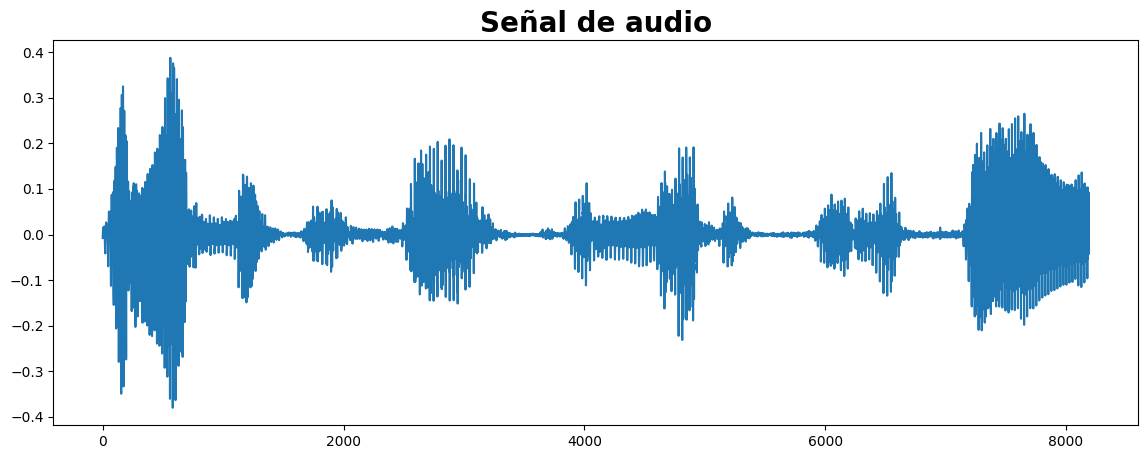

In [13]:
#Prueba
num_audio = 5
#Grafica la señal de primer audio
plt.figure(figsize=(14, 5))
plt.plot(trainAudios[num_audio])
plt.title("Señal de audio", {'fontsize':20, 'fontweight':'bold'})
plt.show()
#Reproduce audio
ipd.Audio(trainAudios[num_audio], rate= sampling_rate)

### Calcula MFCCs

In [14]:
#Parámetros para calcular espectrograma
#-------------------------------------
#Cantidad de datos por audio
Size_data = num_muestras
#Tamaño de la ventana
Size_win = 256
#Tamaño de offset
Size_off = 128
#Número total de ventaneos
total_win_num = int(((Size_data-Size_win)/Size_off)+1)
total_win_num

#Parámetros para calcular MFCCs
#------------------------------
#Frecuencia mínima y máxima
frec_min = 20
frec_max = sampling_rate/2
#numero de bandas de Mel
Mel_bands = 20

In [15]:
#Función para calcular un filtro triangular
def triangular_fun(lower_lim, medium_lim, upper_lim, points_num):
    #Crea vector de coeficientes
    coefficients = np.zeros(points_num)
    #Calcula coeficientes
    for j in range(points_num):
        
        if j>=lower_lim and j<=medium_lim:
            coefficients[j] = (j - lower_lim) / (medium_lim - lower_lim)
        elif j>medium_lim and j<=upper_lim:
            coefficients[j] = (upper_lim - j) / (upper_lim - medium_lim)
        else: 
            coefficients[j] = 0
    #Regresa coeficientes
    return coefficients

def triangular_filter_mat(frec_min, frec_max, Mel_bands):
    #numero de límites de bandas
    Mel_num_limits = Mel_bands+2
    #Frecuencia mínima y máxima en Mels
    frec_min_mel = 2595 * np.log10(1 + frec_min / 700)
    frec_max_mel = 2595 * np.log10(1 + frec_max / 700)
    #Tamaño de límite de separación de bandas en Mels
    separation_mel = (frec_max_mel-frec_min_mel)/(Mel_num_limits-1)
    
    #Crea vecor de límites de bandas mel
    mel_limits = np.zeros(Mel_num_limits)
    #Crea vector de límites equidistantes en Mels
    mel_limits[0] = frec_min_mel
    for i in range(1,Mel_num_limits):
        mel_limits[i] = mel_limits[i-1]+separation_mel
    
    #Crea vecor de límites de bandas en Hertz
    Hz_limits = np.zeros(Mel_num_limits)
    #Conversión de límites de Mel a Hertz
    for i in range(Mel_num_limits):
        Hz_limits[i] = 700 * (10**(mel_limits[i]/ 2595) - 1)
        
    #Crea vecor de límites de bandas en FFT bins
    FFT_bins = np.zeros(Mel_num_limits)
    #Cambia valores de frcuencia (Hertz) por valores al FFT bin más cercano, 
    for i in range(Mel_num_limits):
        FFT_bins[i] = math.floor((Size_win//2+1)*Hz_limits[i]/frec_max)
    FFT_bins[Mel_num_limits-1] = Size_win//2
    
    #Define matriz de filtros triangulares
    Trian_mat= np.zeros((Mel_bands, Size_win//2+1))
    #Calula banco de filtros tringulares
    for i in range(2,Mel_num_limits):
        trian_filter = triangular_fun(FFT_bins[i-2], FFT_bins[i-1], FFT_bins[i], Size_win//2+1)
        Trian_mat[i-2,:] = trian_filter
    
    return Trian_mat

#Preénfasis
def preemphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

#Ventaneo
def windowing(Hamming_window, preemphasized_signal):
    #Define matriz de ventaneos
    Win_mat= np.zeros((Size_win, total_win_num))

    #Ciclo para realizar ventaneo
    cont = 0
    for i in range(total_win_num):
        for j in range(Size_win):
            Win_mat[j][i] = Hamming_window[j]*preemphasized_signal[cont]
            cont = cont+1
        cont = cont-(Size_win-Size_off)
    
    return Win_mat

#fft
def fft_mat(Win_mat):
    #Define matriz de espectrograma
    FFT_mat= np.zeros((1+Size_win//2, total_win_num))
    #Ciclo para realizar FFT por ventana
    for i in range(total_win_num):
        FFT = abs(np.fft.fft(Win_mat[:,i], n = Size_win))
        FFT_mat[:,i] = FFT[0:1+Size_win//2]
    
    return FFT_mat

#Crea ventana Hamming con tamaño Size_win
Hamming_window = np.zeros(Size_win)
for i in range(Size_win):
    Hamming_window[i] = 0.53836-0.46164*(np.cos((2*np.pi*i)/(Size_win-1)));

In [16]:
#Función para calcular MFCCs
def calculoMFCCs(Audios):
    
    number = 1 #Inicializa numero de imagen
    mfccs = [] #Inicializa lista vacía de mfccs
    
    #Caucula Filtros triangulares
    Trian_mat = triangular_filter_mat(frec_min, frec_max, Mel_bands) 
    
    #Ciclo for para calcular MFCCs de cada audio
    for audio in Audios:
        #Espectrograma
        #------------------------------------------------------------------------
        #Preénfasis
        preemphasized_signal = preemphasis(audio)
        #Ventaneo
        Win_mat = windowing(Hamming_window, preemphasized_signal)
        #Fast Fourier Transform (FFT)
        FFT_mat = fft_mat(Win_mat)
        #Aplica banco de filtros triangulares a espectrograma
        Mel_mat = np.dot(Trian_mat, FFT_mat)
        #Aplica transformación logarítmita para escala más adecuada
        Mel_mat_log = 13*np.log(Mel_mat)
        #Aplica transformada de coseno discreta (DCT)
        mfcc = dct(Mel_mat_log, type=2, axis=0, norm='ortho')[:Mel_bands]
     
        #Agrega MFCC resultante a lista
        mfccs.append(mfcc)
        
    return np.asarray(mfccs)

In [17]:
#Caulcula MFCCs de entrenamiento
trainMFCCs = calculoMFCCs(trainAudios)
#Caulcula MFCCs de prueba
testMFCCs = calculoMFCCs(testAudios)
#Caulcula MFCCs de evaluación
evalMFCCs = calculoMFCCs(evalAudios)

In [18]:
#Dimensiones de MFCCs
print('Las dimenciones de los MFCCs de entrenamiento son:\t', trainMFCCs.shape)
print('Las dimenciones de los MFCCs de prueba son:\t\t', testMFCCs.shape)
print('Las dimenciones de los MFCCs de evaluación son:\t\t', evalMFCCs.shape)

#Valor máximo en el arreglo de MFCCs
print('\nEl valor máximo de los MFCCs son: ', np.amax(trainMFCCs))
#Valor mínimo en el arreglo de MFCCs
print('El valor mínimo de los MFCCs son: ', np.amin(trainMFCCs))

Las dimenciones de los MFCCs de entrenamiento son:	 (12000, 20, 63)
Las dimenciones de los MFCCs de prueba son:		 (1200, 20, 63)
Las dimenciones de los MFCCs de evaluación son:		 (800, 20, 63)

El valor máximo de los MFCCs son:  115.34324514890247
El valor mínimo de los MFCCs son:  -351.04987015035755


### Muestra Audios

In [19]:
#Muestra de audio a indicar
num_Audio = 20
AudioSample = trainAudios[num_Audio]

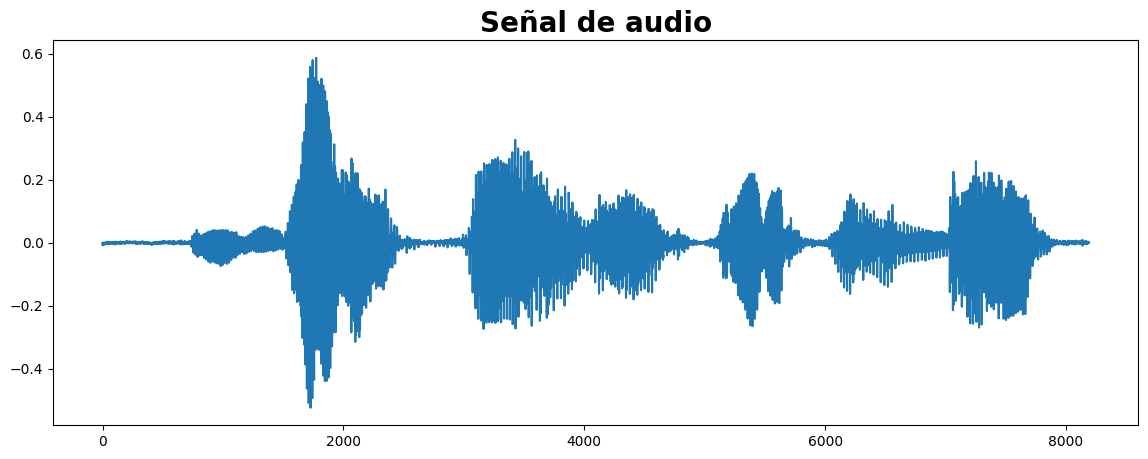

In [20]:
#Grafica la seña de audio elegida
plt.figure(figsize=(14, 5))
plt.plot(AudioSample)
plt.title("Señal de audio", {'fontsize':20, 'fontweight':'bold'})
plt.show()

#Reproduce audio
ipd.Audio(AudioSample, rate= sampling_rate)

(20, 63)


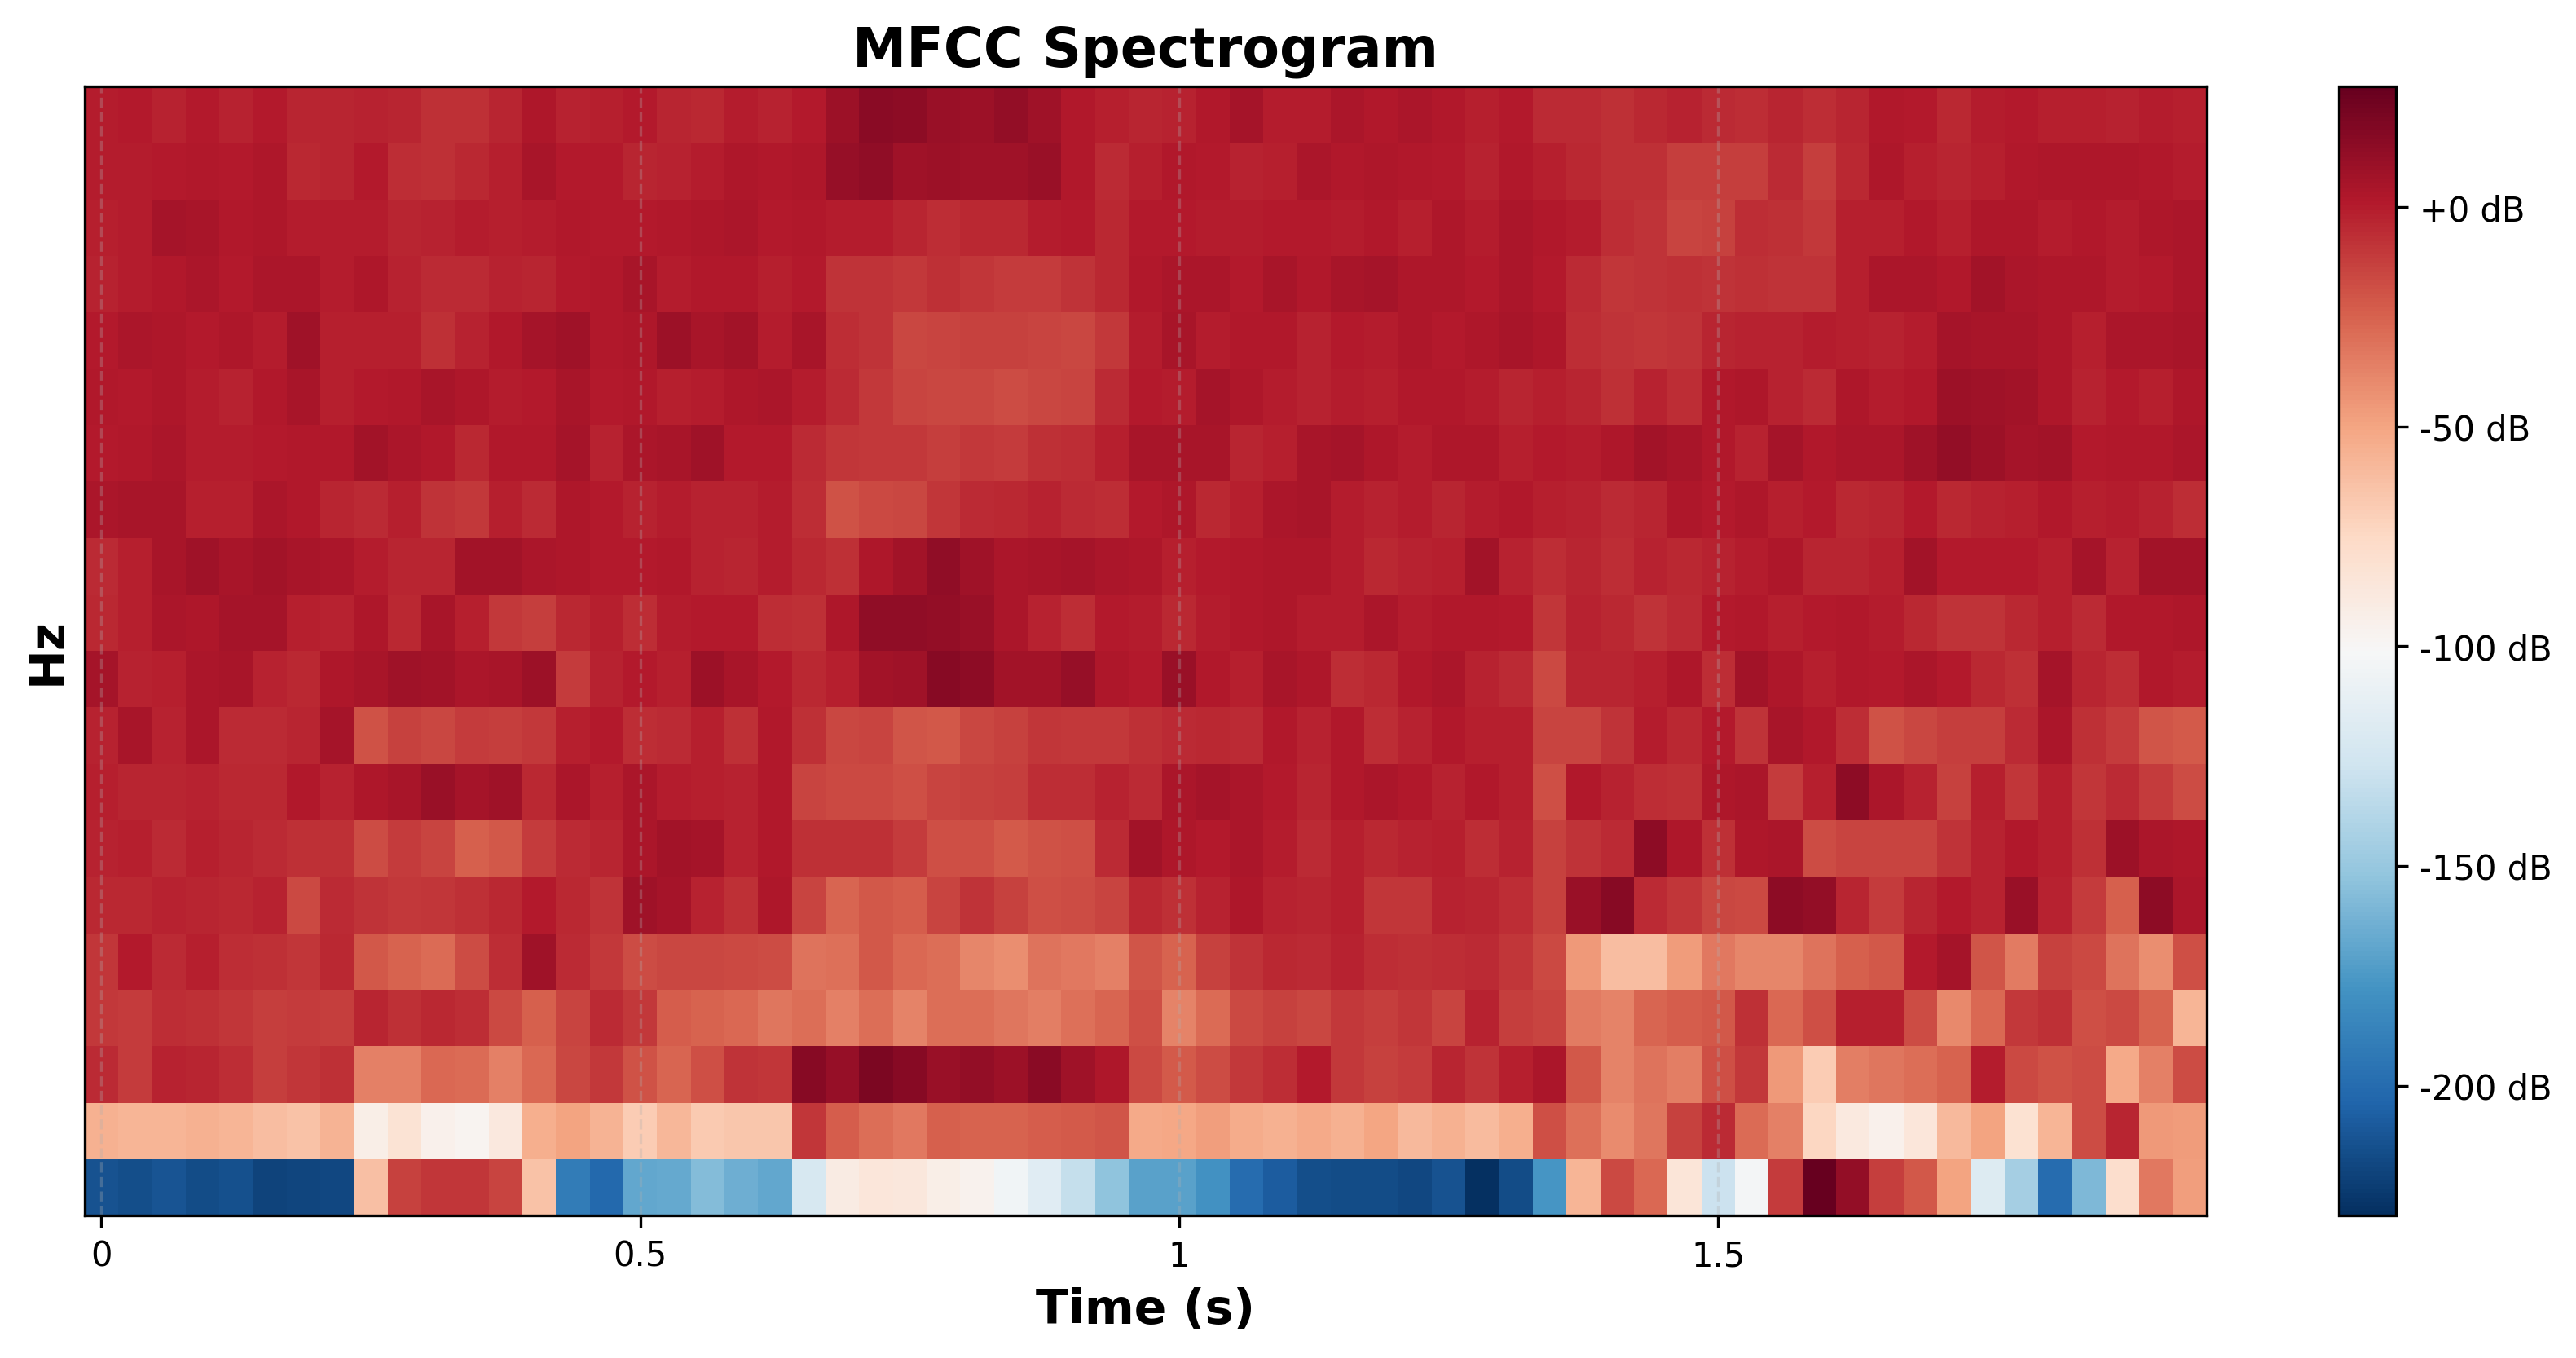

In [21]:
#Muestra MFCC del audio elegido
# Plot the figure
print(testMFCCs[num_Audio].shape)



# Configuración de la figura con mejor calidad
plt.figure(figsize=(14, 6), dpi=300)
librosa.display.specshow(testMFCCs[num_Audio], sr=sampling_rate, hop_length=Size_off, x_axis='time', cmap='RdBu_r')  # Rojo a Azul

# Añadir barra de color y mejorar etiquetas
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)', fontsize=14, fontweight='bold')
plt.ylabel('Hz', fontsize=14, fontweight='bold')
plt.title('MFCC Spectrogram', fontsize=16, fontweight='bold')

# Agregar cuadrícula para mejor visualización
plt.grid(True, linestyle='--', alpha=0.3)

# Mostrar la gráfica mejorada
plt.show()


(20, 63)


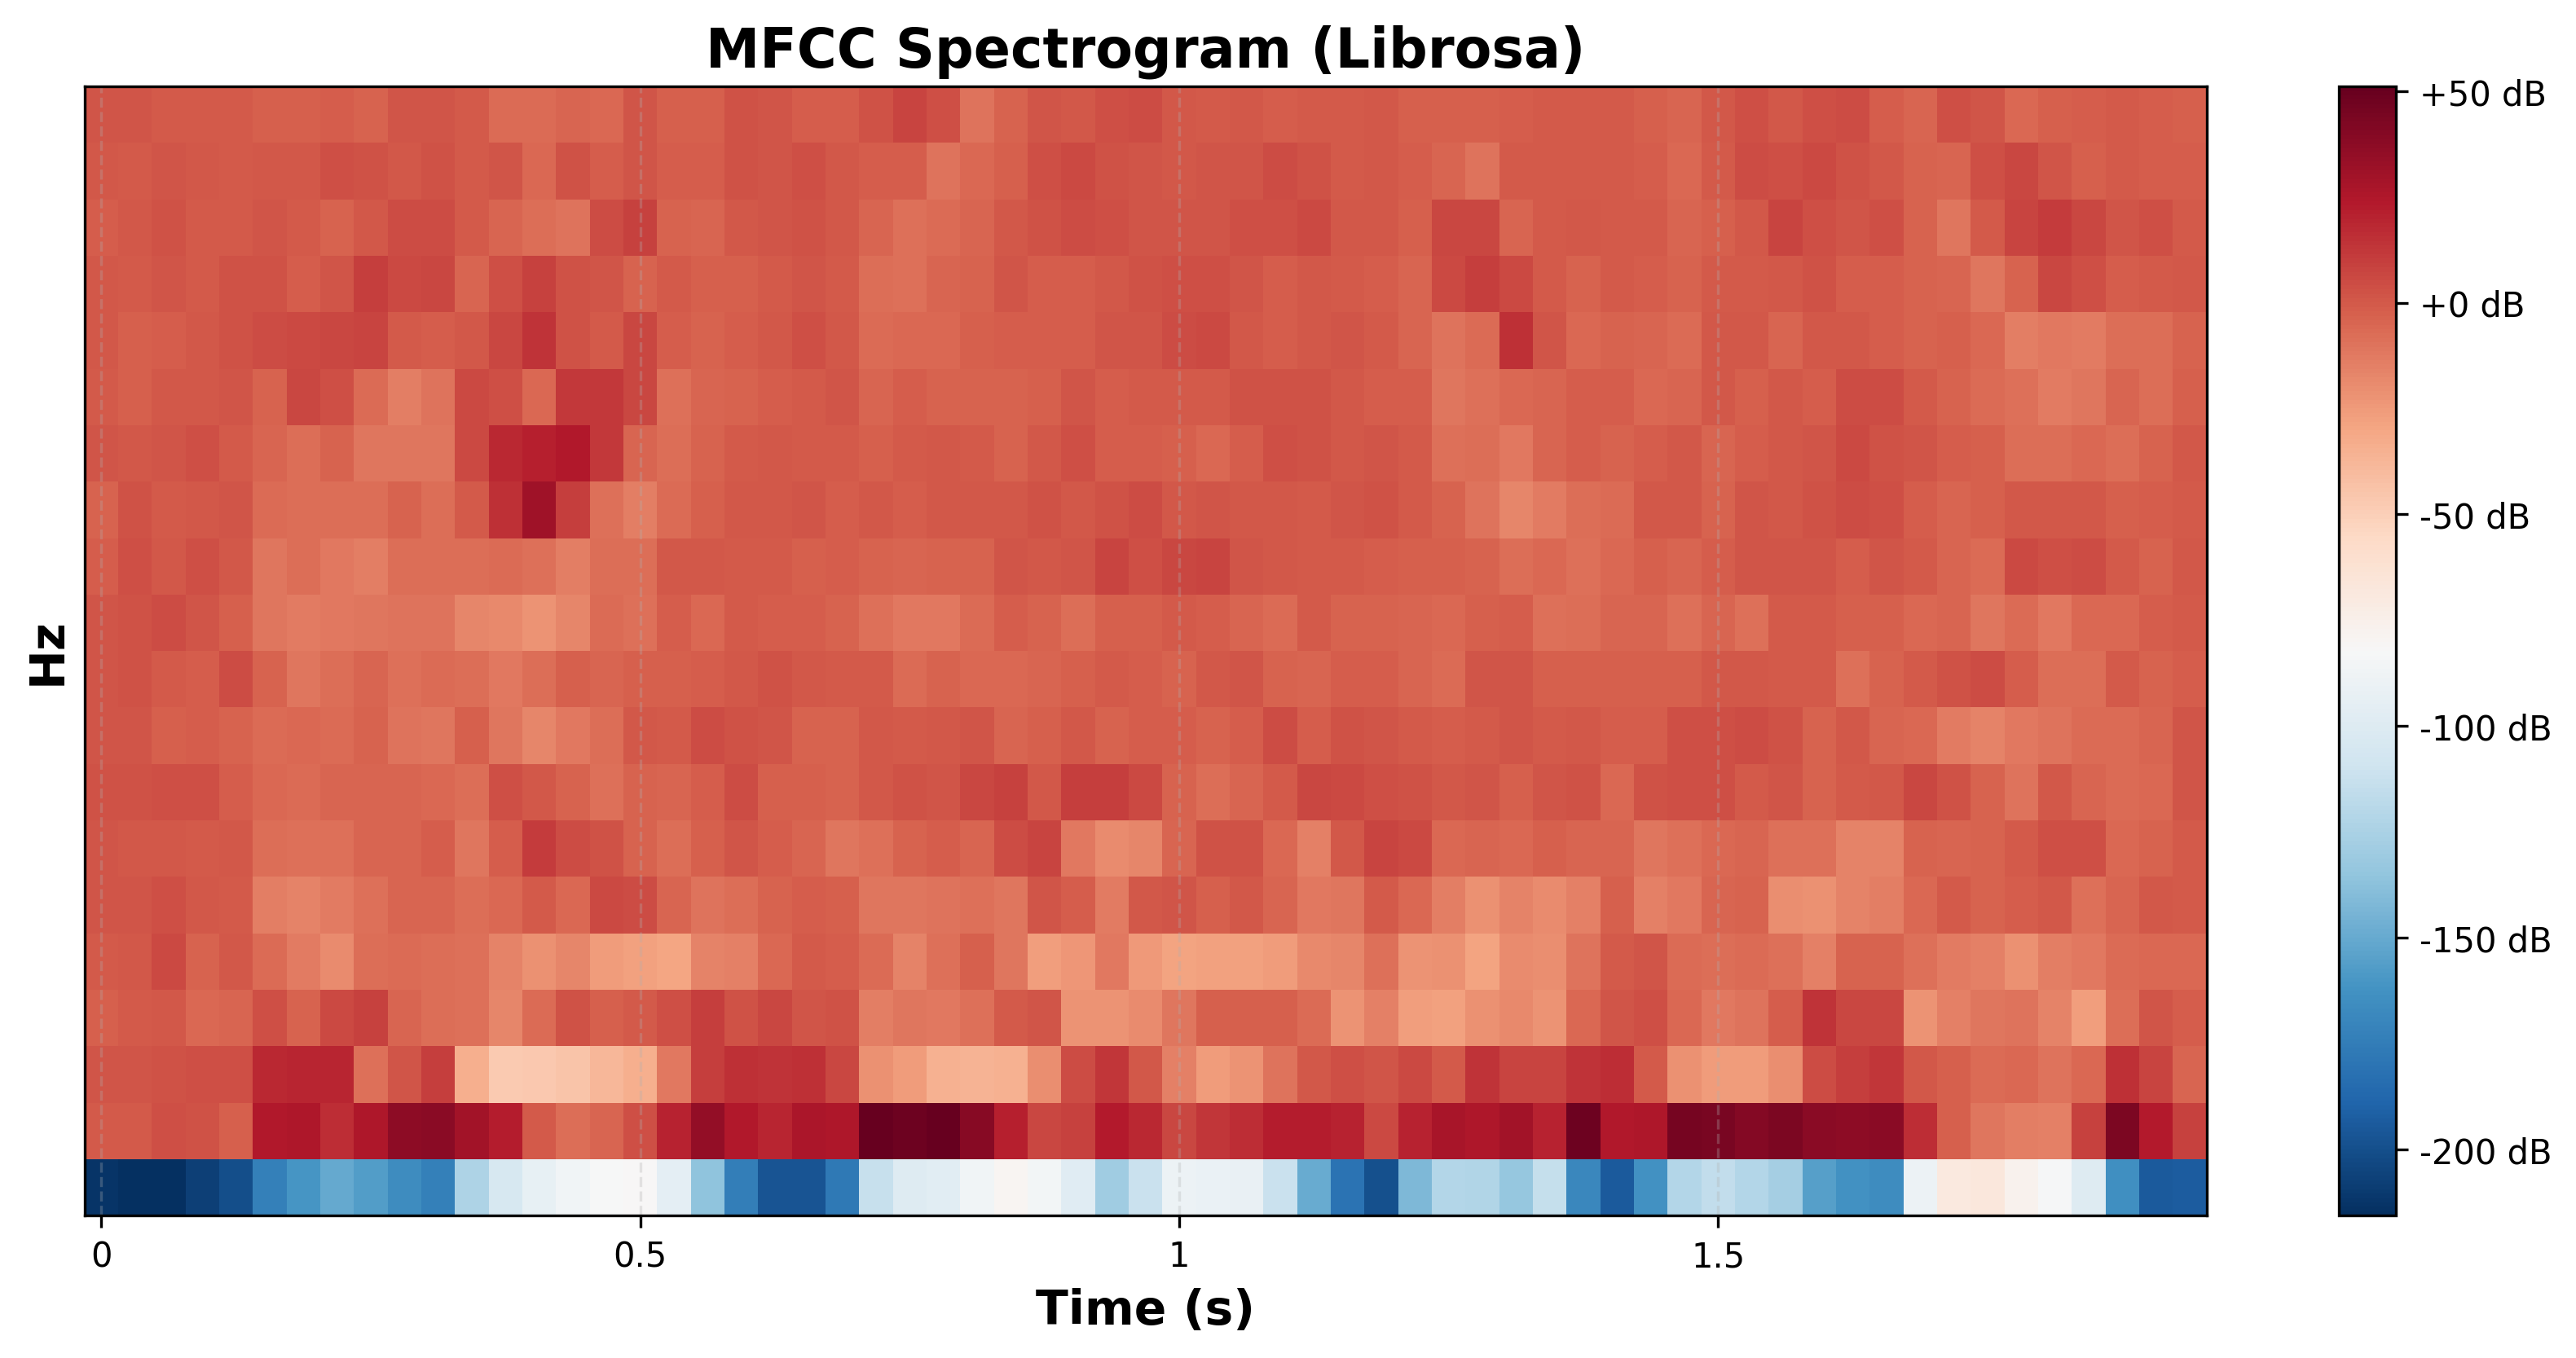

In [22]:
###COMPARATIVA CON LIBROSA###
#Muestra MFCC del audio elegido
mfcc_lib = librosa.feature.mfcc(y=trainAudios[num_Audio], 
                                sr=sampling_rate, 
                                n_mfcc=Mel_bands, 
                                hop_length=Size_off, 
                                n_fft=Size_win,
                                n_mels = Mel_bands,
                               center=False)

print(mfcc_lib.shape)

# Configuración de la figura con mejor calidad
plt.figure(figsize=(14, 6), dpi=300)
librosa.display.specshow(mfcc_lib, sr=sampling_rate, hop_length=Size_off, x_axis='time', cmap='RdBu_r')  # Rojo a Azul

# Añadir barra de color y mejorar etiquetas
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)', fontsize=14, fontweight='bold')
plt.ylabel('Hz', fontsize=14, fontweight='bold')
plt.title('MFCC Spectrogram (Librosa)', fontsize=16, fontweight='bold')

# Agregar cuadrícula para mejor visualización
plt.grid(True, linestyle='--', alpha=0.3)

# Mostrar la gráfica mejorada
plt.show()

###  Modelo MobileNet V3 Small

In [23]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, ZeroPadding2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


def build_mobilenet_v3_optimized(input_shape=(20, 63, 1)):
    # Capa de entrada
    inputs = Input(shape=input_shape)
    
    # Padding para ajustar a la altura mínima requerida por MobileNetV3
    x = ZeroPadding2D(((6, 6), (0, 0)))(inputs)  # (32, 63, 1)
    
    # Base de MobileNetV3 Small personalizada
    base_model = MobileNetV3Small(
        input_shape=(32, 63, 1),
        include_top=False,
        weights=None,
        include_preprocessing=False,
        pooling=None,
        alpha=0.5,  # Reducción de capacidad para evitar overfitting
        dropout_rate=0.1
    )
    
    # Congelar primeras capas para estabilidad
    for layer in base_model.layers[:10]:
        layer.trainable = False
    
    x = base_model(x)
    
    # Capas personalizadas similares a modelo original
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.57))(x)
    x = Dropout(0.36)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.3))(x)
    x = Dropout(0.36)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    # Compilación con parámetros de modelo original
    optimizer = Adam(learning_rate=0.00047)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Uso
#model = build_mobilenet_v3_optimized(input_shape=(20, 63, 1))






In [24]:
#TRAIN


# Se utiliza la forma de los MFCCs de entrenamiento (por ejemplo, (20,63,1))
mobilenet_v3_small_model = build_mobilenet_v3_optimized((trainMFCCs.shape[1], trainMFCCs.shape[2], 1))
new_learning_rate = 0.00047
optimizer = Adam(learning_rate=new_learning_rate)
mobilenet_v3_small_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
mobilenet_v3_small_model.summary()



epochs=150
# Crear ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_model_checkpoint/best_model_epoch_Mobile{epoch:02d}.h5', monitor='val_loss', save_best_only=True, 
                                   save_weights_only=False, mode='min', verbose=1)
# Luego ejecutas model.fit
history = mobilenet_v3_small_model.fit(trainMFCCs, trainLabels, validation_data=(evalMFCCs, evalLabels), 
                    epochs=epochs, batch_size=32, verbose=2, callbacks=[model_checkpoint])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 63, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 32, 63, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 1, 2, 288)      │       278,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 288)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,833 (1.10 MB)

 Trainable params: 281,849 (1.08 MB)

 Non-trainable params: 6,984 (27.28 KB)

Epoch 1/150

Epoch 1: val_loss improved from inf to 2.34061, saving model to best_model_checkpoint/best_model_epoch_Mobile01.h5


375/375 - 15s - 40ms/step - accuracy: 0.6068 - loss: 12.3479 - val_accuracy: 0.5000 - val_loss: 2.3406
Epoch 2/150

Epoch 2: val_loss improved from 2.34061 to 0.87512, saving model to best_model_checkpoint/best_model_epoch_Mobile02.h5


375/375 - 9s - 23ms/step - accuracy: 0.6926 - loss: 1.2496 - val_accuracy: 0.5000 - val_loss: 0.8751
Epoch 3/150

Epoch 3: val_loss improved from 0.87512 to 0.73911, saving model to best_model_checkpoint/best_model_epoch_Mobile03.h5


375/375 - 9s - 25ms/step - accuracy: 0.7257 - loss: 0.6668 - val_accuracy: 0.5000 - val_loss: 0.7391
Epoch 4/150

Epoch 4: val_loss did not improve from 0.73911
375/375 - 9s - 25ms/step - accuracy: 0.7613 - loss: 0.5815 - val_accuracy: 0.5000 - val_loss: 0.7521
Epoch 5/150

Epoch 5: val_loss did not improve from 0.73911
375/375 - 9s - 24ms/step - accuracy: 0.7736 - loss: 0.5467 - val_accuracy: 0.5000 - val_loss: 0.7460
Epoch 6/150

Epoch 6: val_loss did not improve from 0.73911
375/375 - 9s - 23ms/step - accuracy: 0.7928 - loss: 0.5178 - val_accuracy: 0.5000 - val_loss: 0.7489
Epoch 7/150

Epoch 7: val_loss did not improve from 0.73911
375/375 - 9s - 25ms/step - accuracy: 0.8120 - loss: 0.4879 - val_accuracy: 0.5000 - val_loss: 0.7414
Epoch 8/150

Epoch 8: val_loss improved from 0.73911 to 0.73887, saving model to best_model_checkpoint/best_model_epoch_Mobile08.h5


375/375 - 9s - 24ms/step - accuracy: 0.8256 - loss: 0.4598 - val_accuracy: 0.5000 - val_loss: 0.7389
Epoch 9/150

Epoch 9: val_loss did not improve from 0.73887
375/375 - 9s - 24ms/step - accuracy: 0.8342 - loss: 0.4376 - val_accuracy: 0.5000 - val_loss: 0.7448
Epoch 10/150

Epoch 10: val_loss did not improve from 0.73887
375/375 - 9s - 24ms/step - accuracy: 0.8530 - loss: 0.4011 - val_accuracy: 0.5000 - val_loss: 0.7473
Epoch 11/150

Epoch 11: val_loss did not improve from 0.73887
375/375 - 9s - 25ms/step - accuracy: 0.8654 - loss: 0.3806 - val_accuracy: 0.5063 - val_loss: 0.7508
Epoch 12/150

Epoch 12: val_loss did not improve from 0.73887
375/375 - 9s - 24ms/step - accuracy: 0.8780 - loss: 0.3507 - val_accuracy: 0.5113 - val_loss: 0.7956
Epoch 13/150

Epoch 13: val_loss did not improve from 0.73887
375/375 - 9s - 24ms/step - accuracy: 0.8878 - loss: 0.3362 - val_accuracy: 0.5900 - val_loss: 0.7417
Epoch 14/150

Epoch 14: val_loss did not improve from 0.73887
375/375 - 9s - 25ms/step

375/375 - 9s - 23ms/step - accuracy: 0.9151 - loss: 0.2712 - val_accuracy: 0.6650 - val_loss: 0.7325
Epoch 17/150

Epoch 17: val_loss did not improve from 0.73246
375/375 - 9s - 23ms/step - accuracy: 0.9241 - loss: 0.2540 - val_accuracy: 0.6862 - val_loss: 0.8691
Epoch 18/150

Epoch 18: val_loss did not improve from 0.73246
375/375 - 9s - 23ms/step - accuracy: 0.9354 - loss: 0.2285 - val_accuracy: 0.6900 - val_loss: 0.8302
Epoch 19/150

Epoch 19: val_loss did not improve from 0.73246
375/375 - 9s - 24ms/step - accuracy: 0.9373 - loss: 0.2232 - val_accuracy: 0.6612 - val_loss: 0.9673
Epoch 20/150

Epoch 20: val_loss did not improve from 0.73246
375/375 - 9s - 23ms/step - accuracy: 0.9353 - loss: 0.2230 - val_accuracy: 0.6625 - val_loss: 1.0148
Epoch 21/150

Epoch 21: val_loss did not improve from 0.73246
375/375 - 8s - 22ms/step - accuracy: 0.9427 - loss: 0.2024 - val_accuracy: 0.6637 - val_loss: 1.0499
Epoch 22/150

Epoch 22: val_loss did not improve from 0.73246
375/375 - 8s - 22ms/st

In [25]:
# FLOPS


from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2


# Obtener el input shape del modelo y establecer el batch_size a 1.
batch_size=1
# model.input_shape suele ser algo como (None, height, width, channels)
concrete_input_shape = [1] + list(mobilenet_v3_small_model.input_shape[1:])

# Crear una función tf.function para el forward pass
run_model = tf.function(lambda x: mobilenet_v3_small_model(x))

# Obtener la función concreta utilizando el input_shape derivado del modelo
concrete_func = run_model.get_concrete_function(tf.TensorSpec(concrete_input_shape, tf.float32))

# Convertir el modelo a un grafo congelado
frozen_func = convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

# Usar el profiler de TensorFlow para calcular los FLOPS.
with tf.compat.v1.Session() as sess:
    tf.import_graph_def(graph_def, name='')
    options = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops_profile = tf.compat.v1.profiler.profile(sess.graph, options=options)
    
    total_flops = flops_profile.total_float_ops
    print("FLOPS:", total_flops)



I0000 00:00:1742000481.497855    9903 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1742000481.497951    9903 single_machine.cc:374] Starting new session


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================
 2016769

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math be

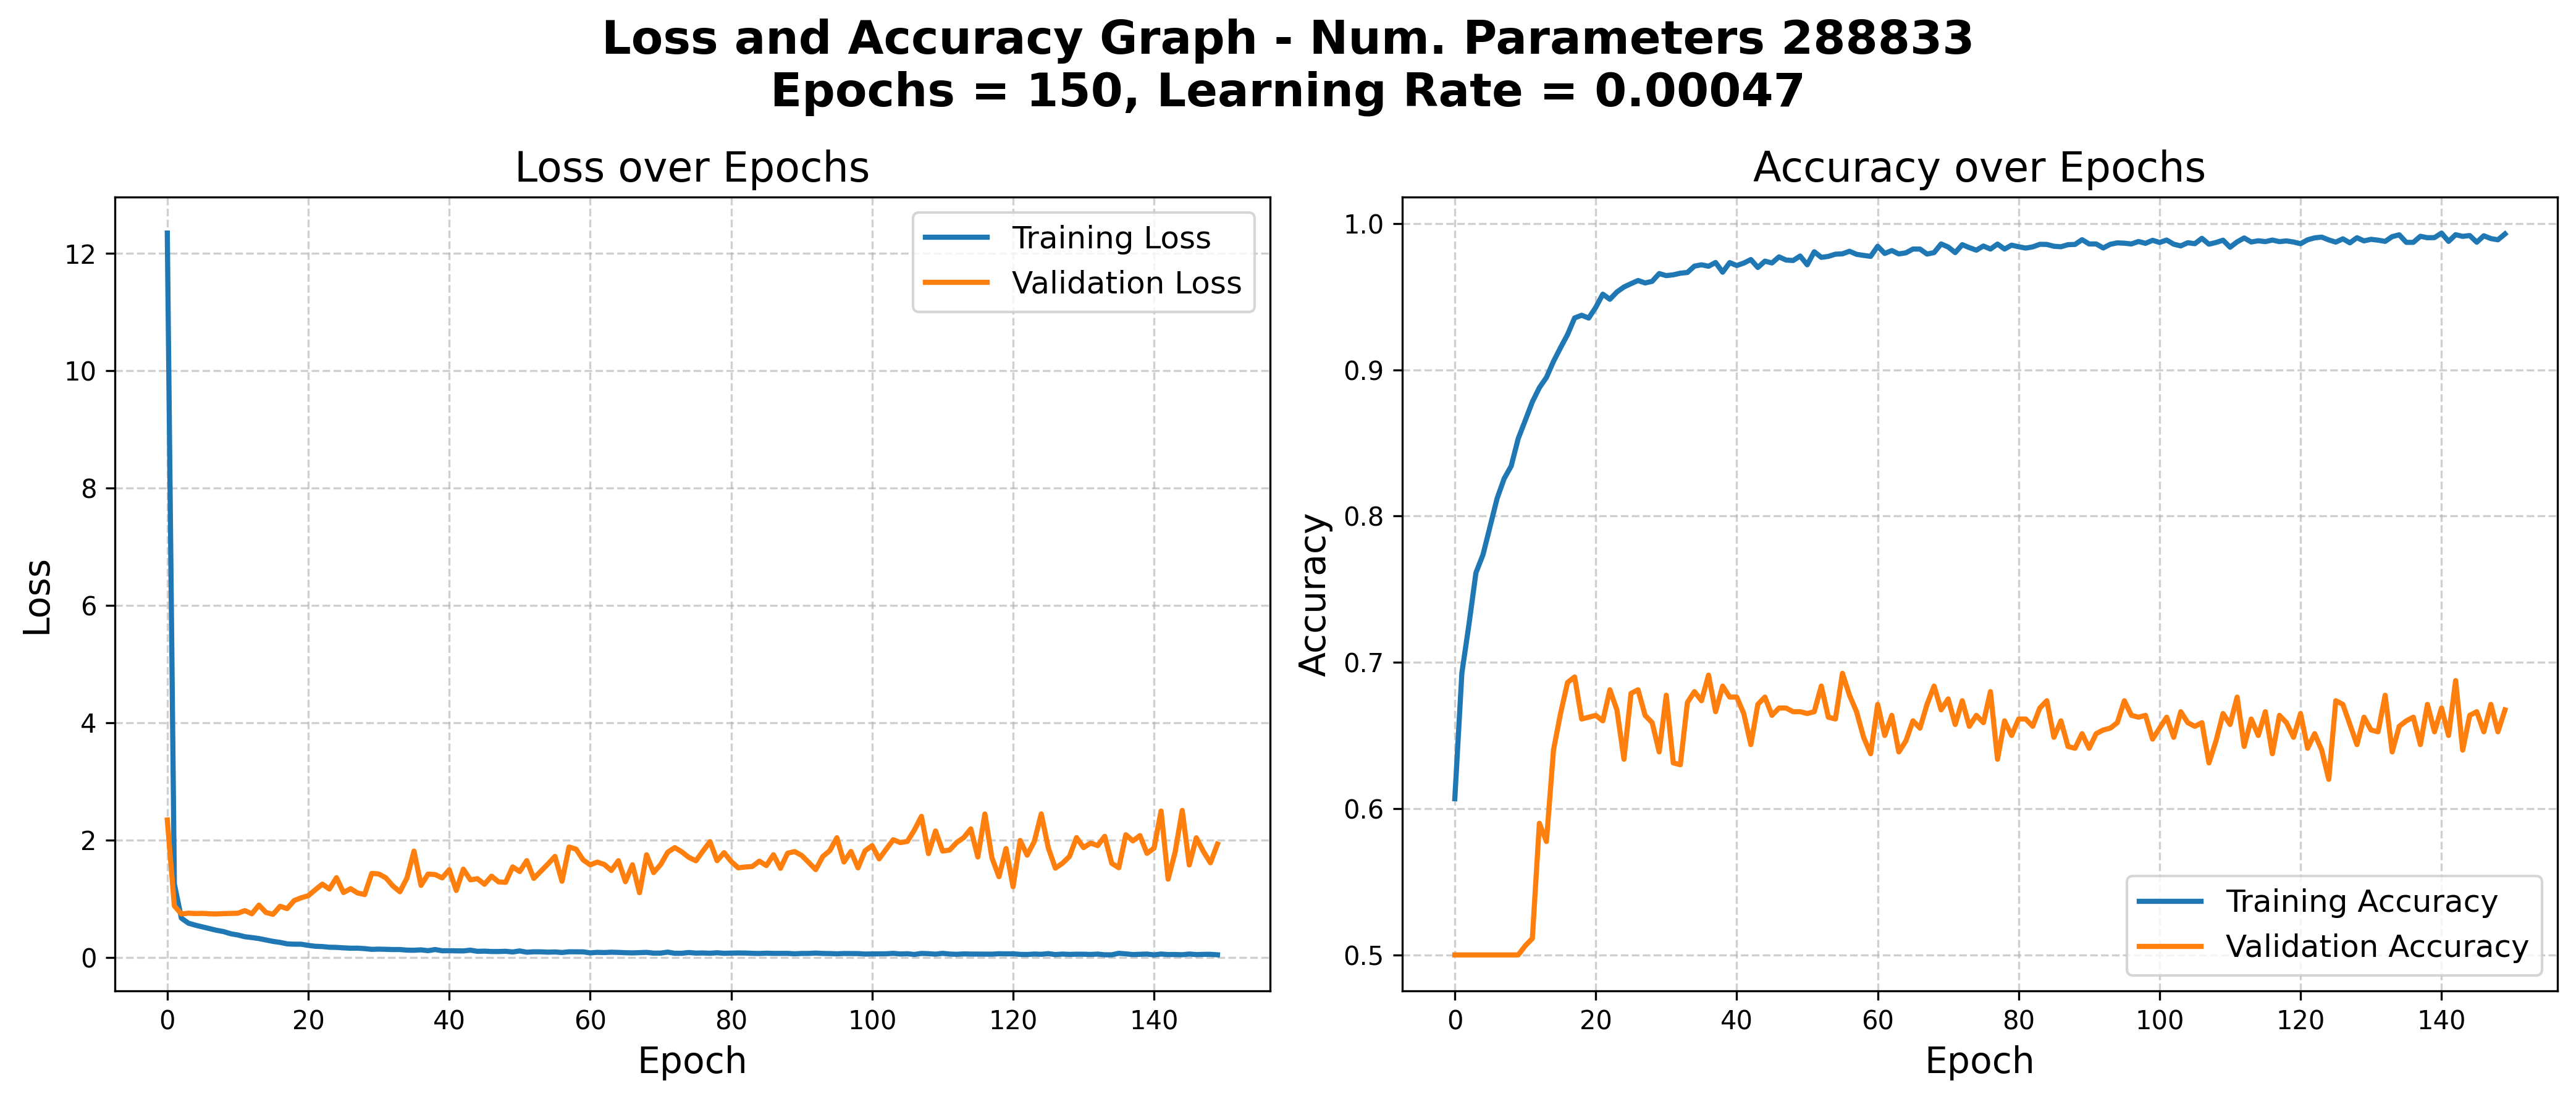

In [26]:
# LOSS AND ACCURACY GRAPH
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear figura con mayor calidad
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Gráfico de pérdida (Loss)
axes[0].plot(loss, label='Training Loss', linewidth=2)
axes[0].plot(val_loss, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].set_title('Loss over Epochs', fontsize=16)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de precisión (Accuracy)
axes[1].plot(accuracy, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accuracy, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_title('Accuracy over Epochs', fontsize=16)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)

# Título general con más claridad
plt.suptitle(f"Loss and Accuracy Graph - Num. Parameters {mobilenet_v3_small_model.count_params()}\n"
             f"Epochs = {epochs}, Learning Rate = {new_learning_rate}",
             fontsize=18, fontweight='bold')

# Ajuste automático para evitar superposiciones
plt.tight_layout()

# Guardar la imagen en alta calidad
plt.savefig("training_metrics.png", dpi=300, bbox_inches="tight", format="png")

# Mostrar la gráfica
plt.show()

In [27]:
#Carga Mejor modelo
from keras.models import load_model
# Cargar el modelo guardado en "best_model.h5"
model = load_model('best_model_checkpoint/best_model_epoch_133.h5')

# Evaluación en el conjunto test
_, accuracy = mobilenet_v3_small_model.evaluate(testMFCCs, testLabels)
print(f'Accuracy: {accuracy}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6487 - loss: 1.9077
Accuracy: 0.675000011920929


In [28]:
# Evaluación en el conjunto train
_, accuracy = mobilenet_v3_small_model.evaluate(trainMFCCs, trainLabels)
print(f'Accuracy: {accuracy}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9967 - loss: 0.0225
Accuracy: 0.9950000047683716


### Exporta Modelo

In [29]:
#Exporta el modelo
#export_dir = 'CNN_Python/saved_models/modelo_tesis_binario_Angry_finalv5'
# tf.saved_model.save(model, export_dir)
#tf.keras.models.save_model(model, export_dir)

export_dir = 'saved_models/modelo_tesis_binario_Angry_finalv5/saved_modelMobileNetV3S.keras'
tf.keras.models.save_model(mobilenet_v3_small_model, export_dir)

### Pruebas

In [30]:
#Define Umbral
umbral = 0.5
#Predice probabilidades de las clases (de 0 a 1)
predict = mobilenet_v3_small_model.predict(evalMFCCs)
# Aplica el umbral para convertir las predicciones en 0 o 1
Label_predict = (predict > umbral).astype(int)
#Dimenciones de vector de etiquetas
print("Dimensiones de vector de etiquetas: ", Label_predict.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Dimensiones de vector de etiquetas:  (800, 1)


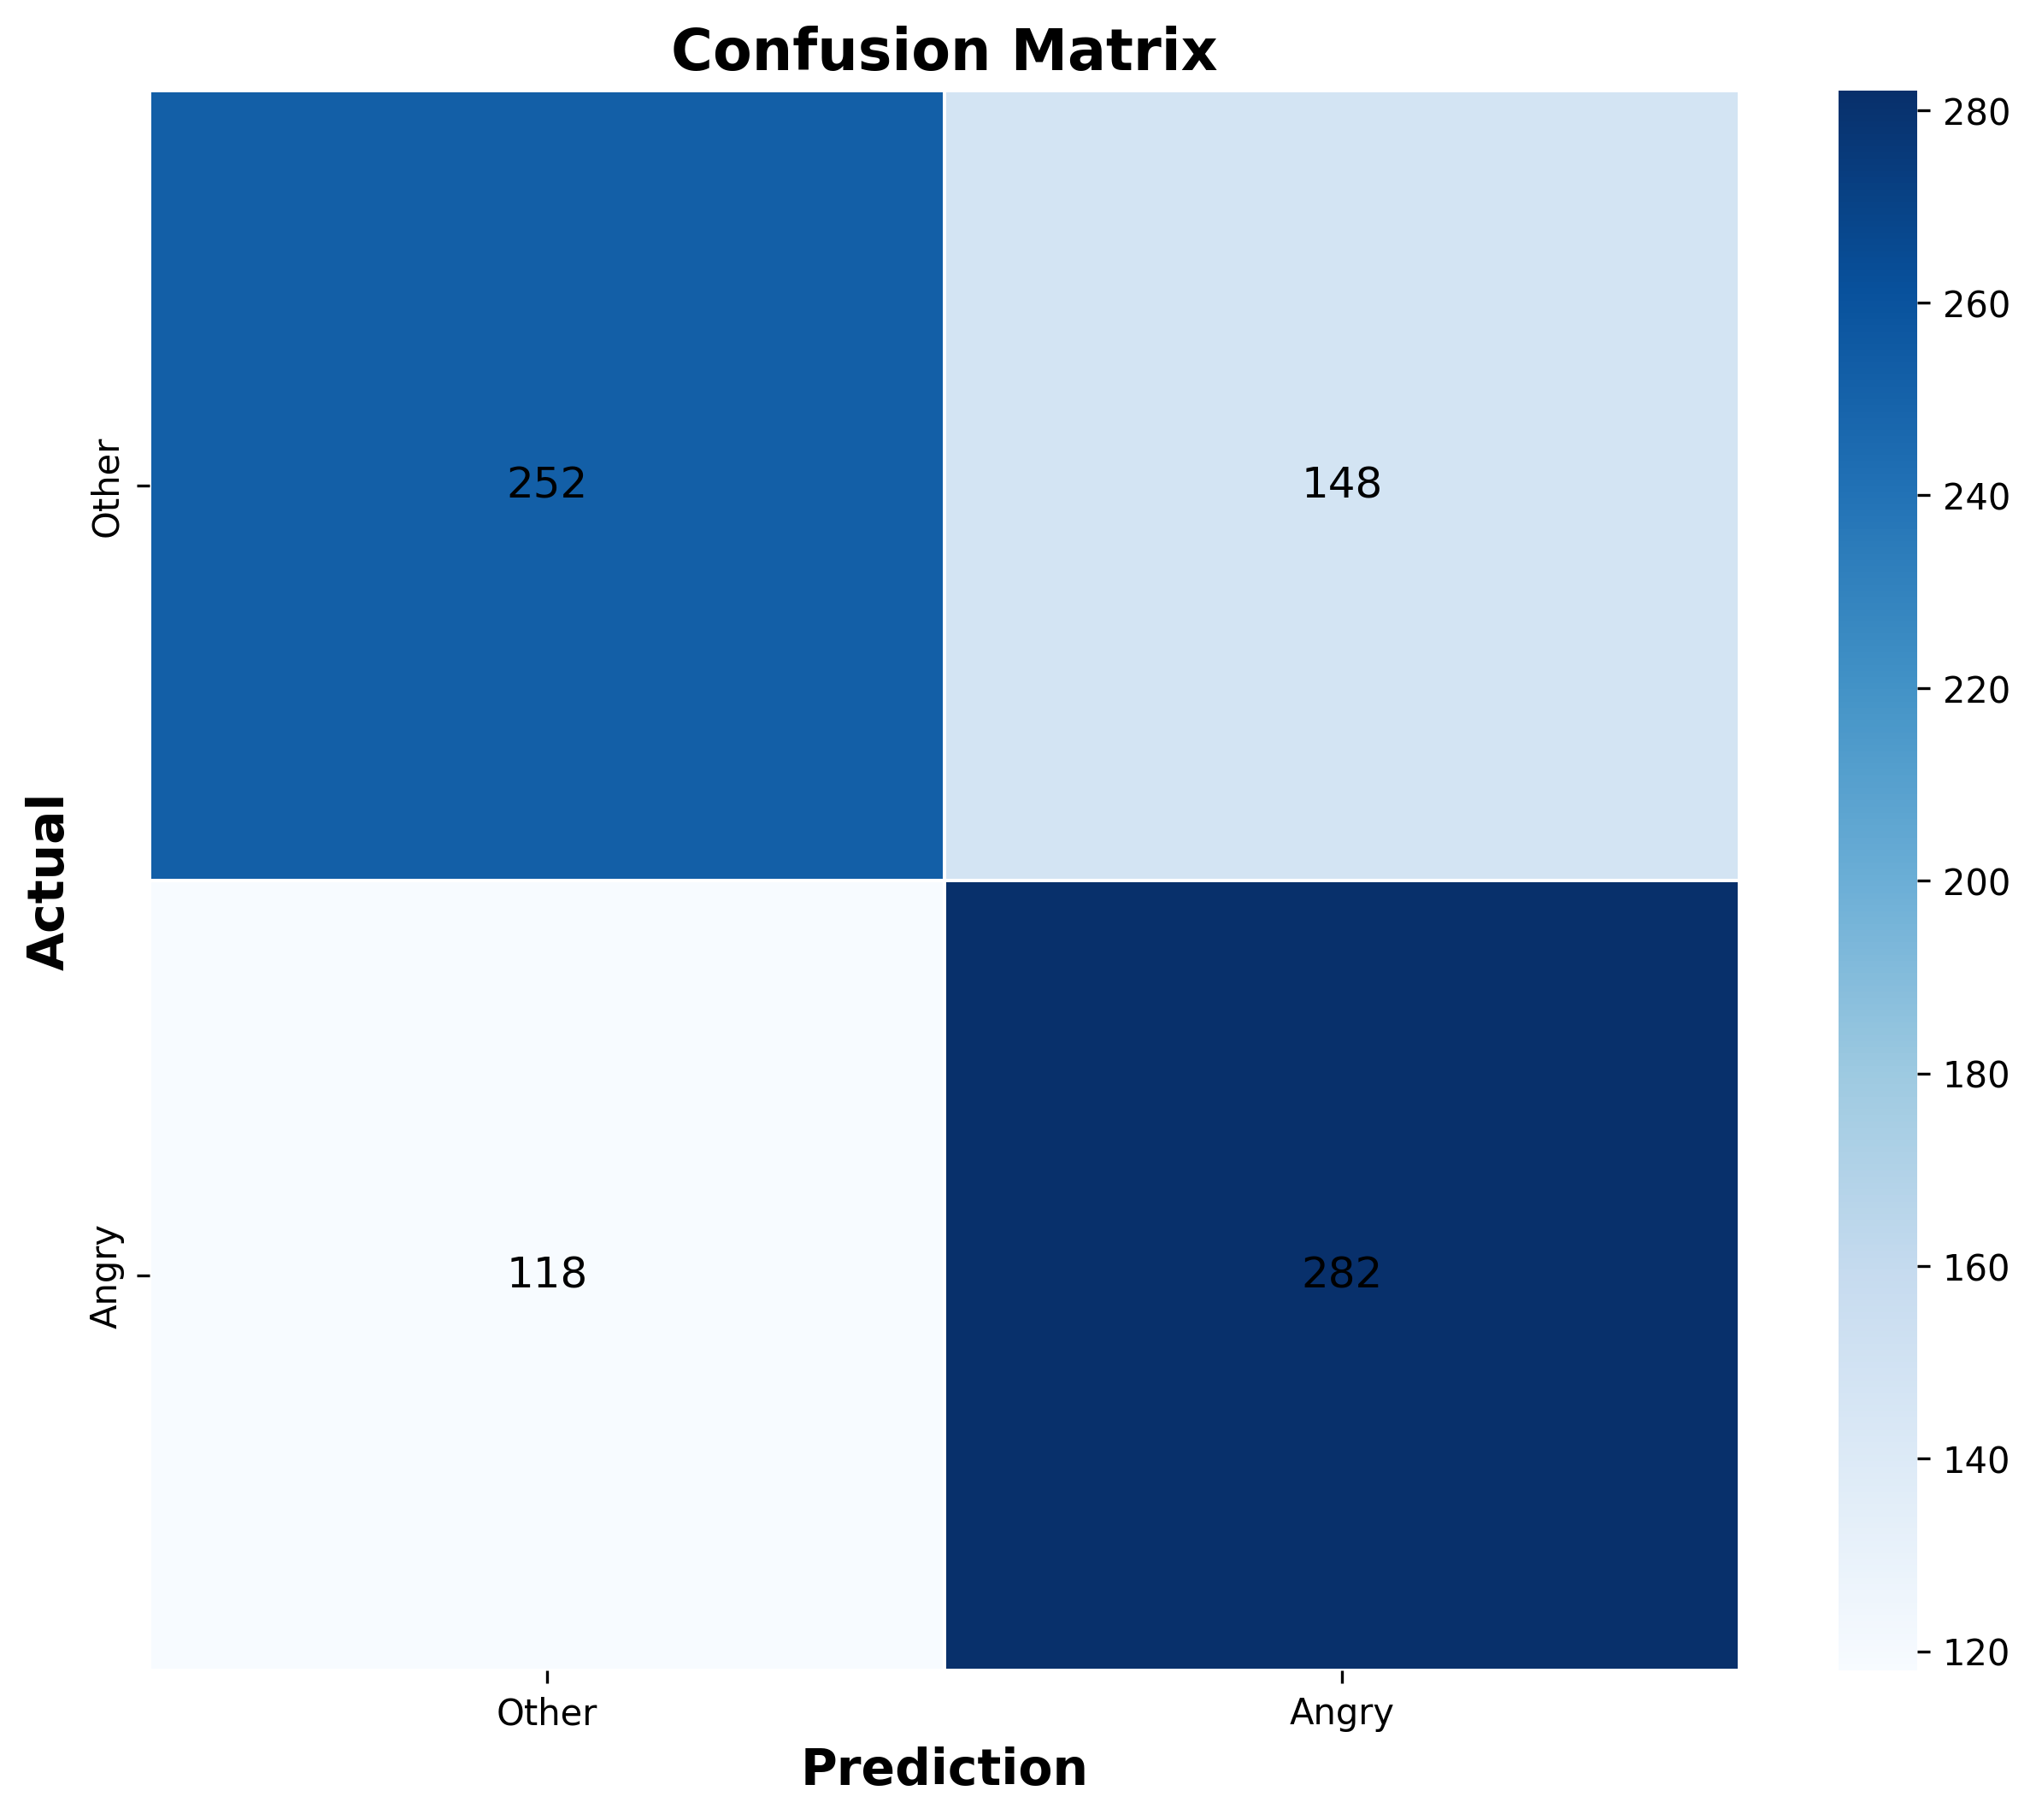

In [31]:
#Calcula matriz de confusión
con_mat = confusion_matrix(evalLabels, Label_predict, labels=clases_vec)
#Convierte matriz en un pandas dataframe
#Rows =    Valores verdaderos
#Columns = Valores predichos
con_mat_df = pd.DataFrame(con_mat, index=emotion_vec, columns=emotion_vec)

# Crear un mapa de calor con mayor calidad
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(con_mat_df, annot=True, fmt='d', cmap='Blues', 
            linewidths=0.5, annot_kws={'size': 12, 'color': 'black'})

# Etiquetas y título mejorados
plt.xlabel('Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Mostrar la gráfica
plt.show()

In [32]:
# Evaluación en el conjunto de validación
_, accuracy = mobilenet_v3_small_model.evaluate(evalMFCCs, evalLabels)

print(f'Accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6732 - loss: 1.7983
Accuracy: 0.6675000190734863


In [33]:
# TABLA

import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Assume you have defined your MiniVGG16 model and it's stored in the variable `model`
# model = MiniVGG16(...) 


# Calculate the total number of parameters in the model
total_params = mobilenet_v3_small_model.count_params()

# Heuristic to determine computational complexity based on parameter count
if total_params < 1e6:
    model_complexity = "Baja"   # Low complexity
elif total_params < 1e7:
    model_complexity = "Media"  # Medium complexity
else:
    model_complexity = "Alta"   # High complexity

# Define model name
model_name = "MobileNetV3Small"

# Crea lista vacía de estadísticos
statistics = []

# Ciclo para calcular especificidad, recall, precision y f_score
for label in range(0, 2):
    precision, recall, f_score, support = precision_recall_fscore_support(
        evalLabels == label,
        Label_predict == label
    )
    # Se añade a cada registro:
    # [Nombre del modelo, emoción, especificidad, recall, precision, f_score, FLOPS, complejidad computacional]
    statistics.append([
        model_name,
        emotion_vec[label],
        recall[0],
        recall[1],
        precision[1],
        f_score[1],
        total_flops,
        model_complexity
    ])

# Convierte resultados en dataframe y agrega columnas
statistics = pd.DataFrame(statistics, columns=[
    "Model", "Emotion", "Specificity", "Recall", "Precision", "F_Score", "FLOPS", "Comp_Complexity"
])
statistics


,Model,Emotion,Specificity,Recall,Precision,F_Score,FLOPS,Comp_Complexity
0,MobileNetV3Small,Other,0.705,0.630,0.681081,0.654545,2016769,Baja
1,MobileNetV3Small,Angry,0.630,0.705,0.655814,0.679518,2016769,Baja


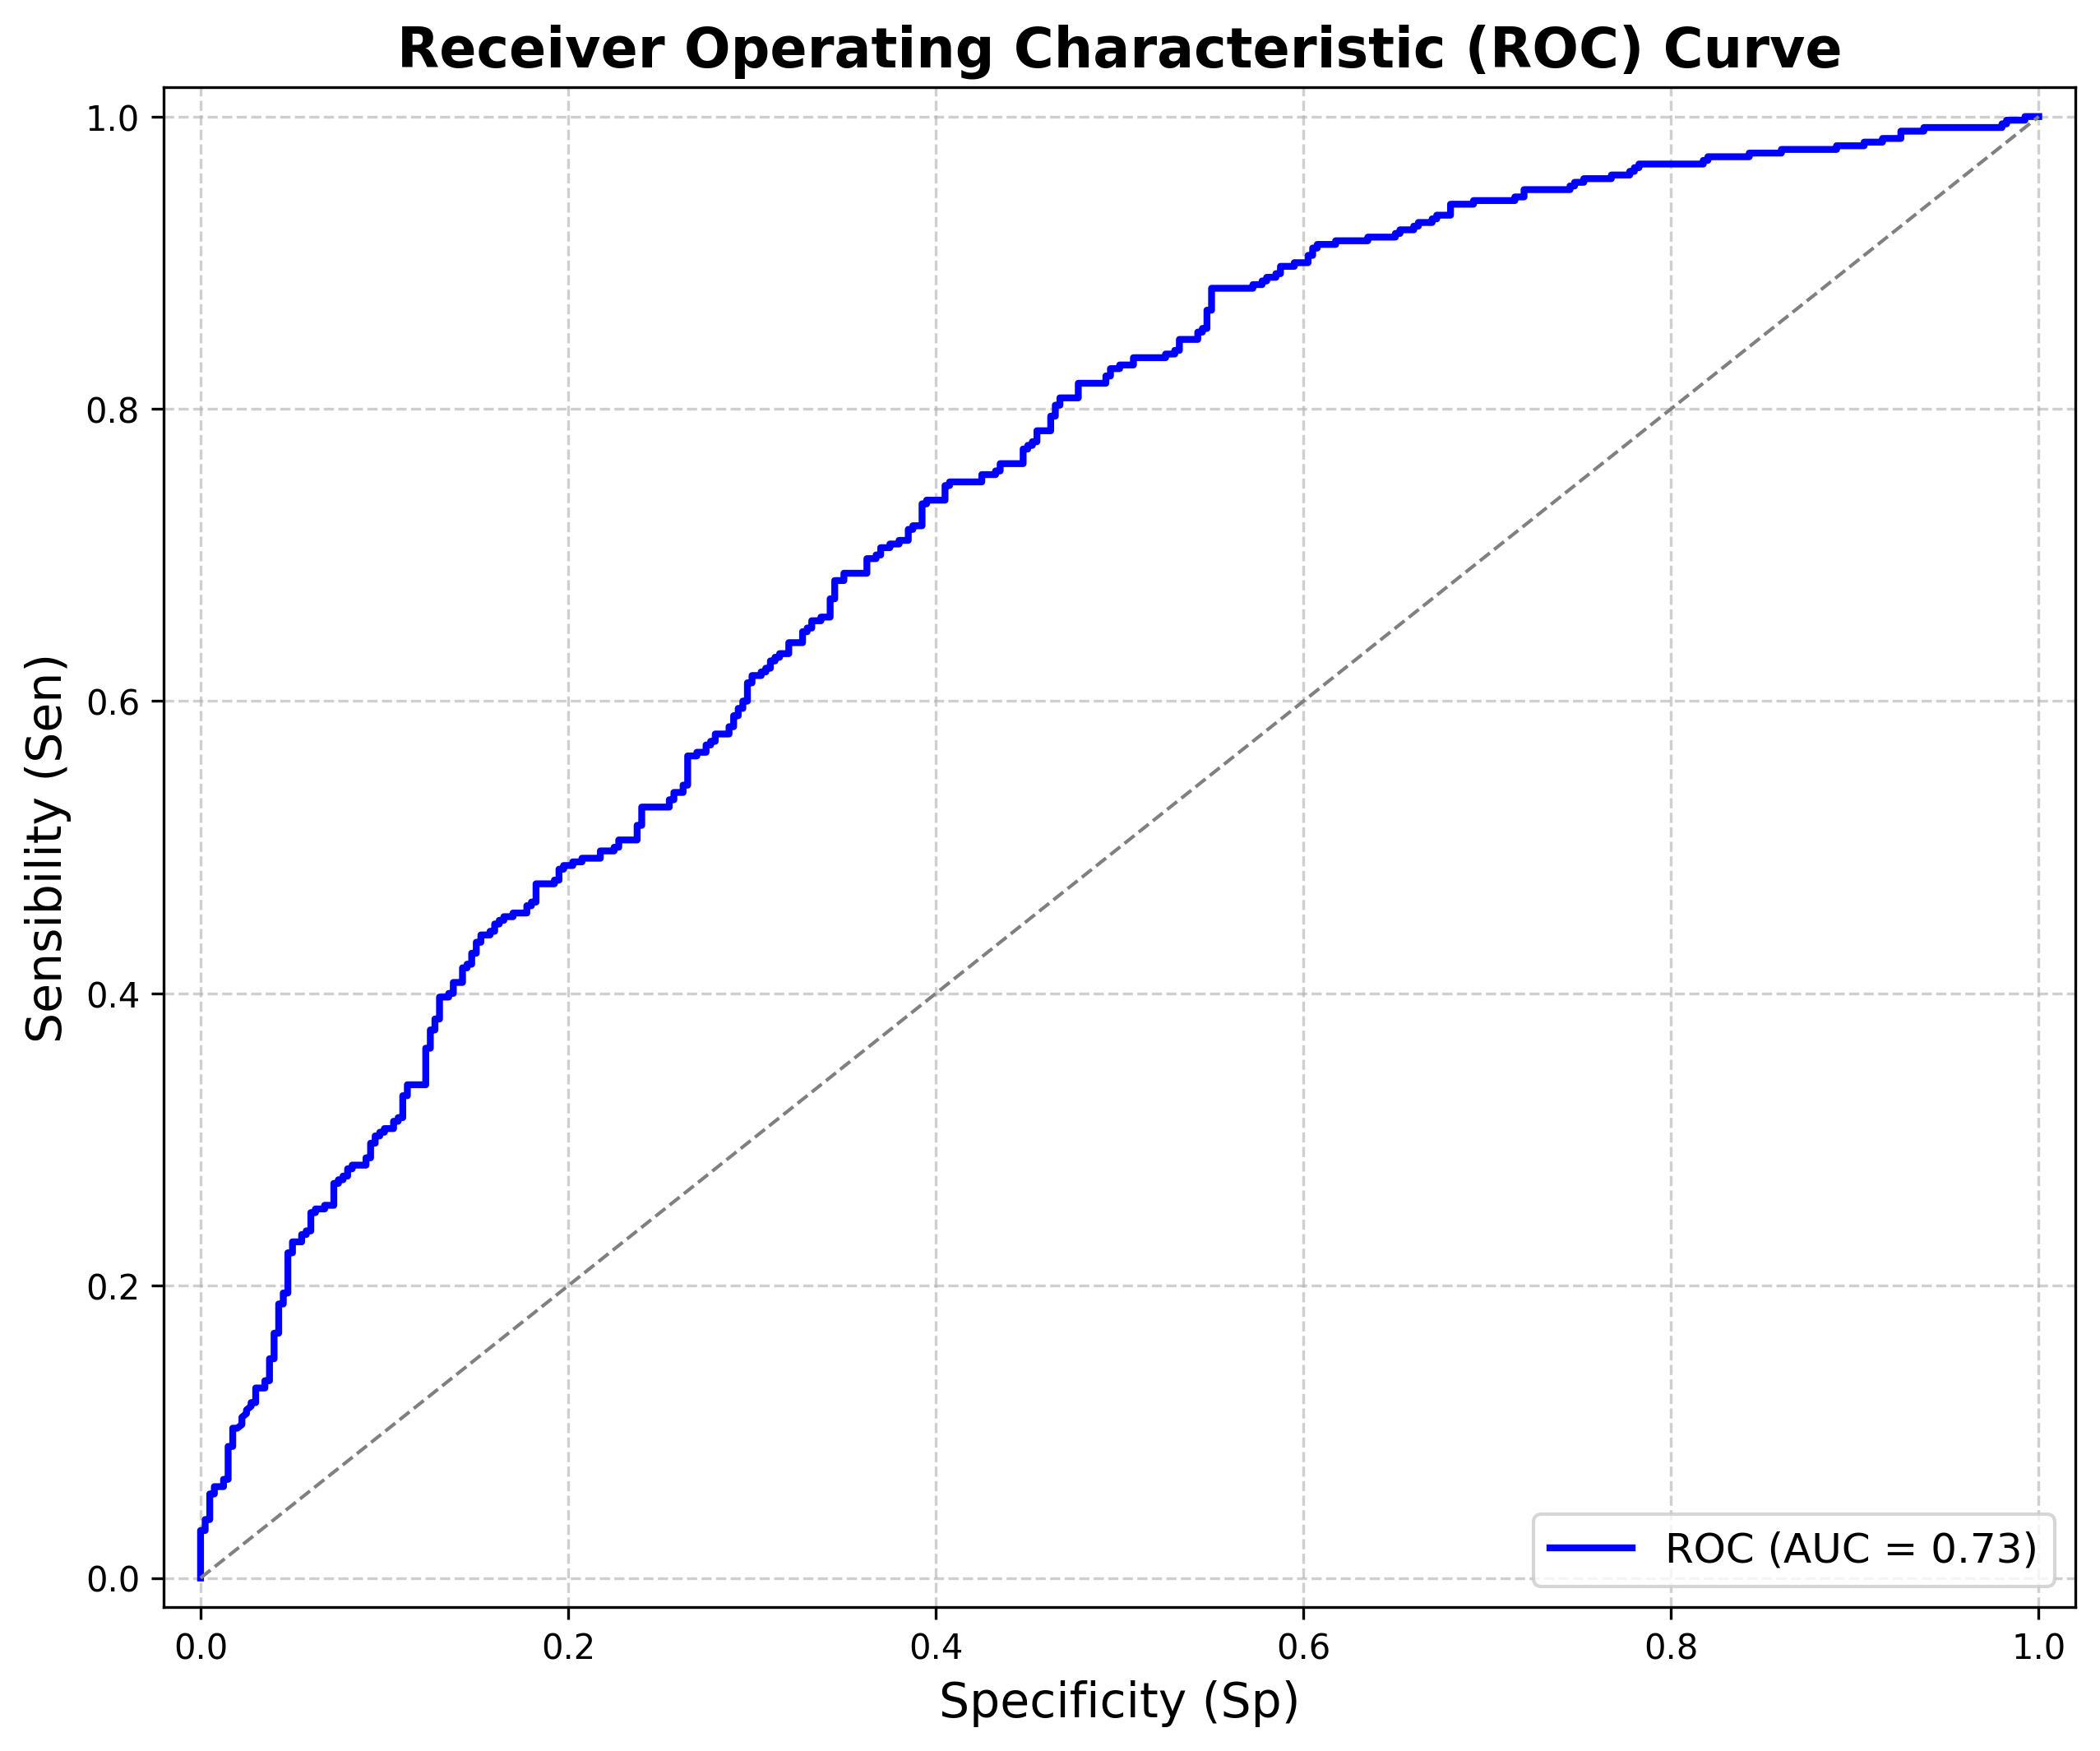

In [34]:
#CURVA ROC


fpr, tpr, umbrales = roc_curve(evalLabels, predict)
area_bajo_curva = roc_auc_score(evalLabels, predict)

# Mejora la calidad de la imagen
plt.figure(figsize=(10, 8), dpi=300)

# Graficar la Curva ROC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {area_bajo_curva:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Línea de referencia

# Configuración de ejes y estilo
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Specificity (Sp)', fontsize=14)
plt.ylabel('Sensibility (Sen)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')

# Agregar cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar leyenda
plt.legend(loc='lower right', fontsize=12)

# Mostrar la gráfica
plt.show()

# TENSORFLOW LITE

### Convierte Modelo

In [42]:
#Path del modelo
model_dir = 'saved_models/modelo_tesis_binario_Angry_finalv5'

In [43]:
#Convierte el modelo con tensorflow lite desde un modelo guardado
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
#Guarda modelo en variable
tflite_model = converter.convert()

2024-04-09 04:58:00.670833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-09 04:58:00.670882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-09 04:58:00.671390: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_models/modelo_tesis_binario_Angry_finalv5
2024-04-09 04:58:00.678619: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-09 04:58:00.678639: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: saved_models/modelo_tesis_binario_Angry_finalv5
2024-04-09 04:58:00.693398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-04-09 04:58:00.696122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-09 04:58:00.737009: I tensorflow/cc/saved_model/loader.cc:213] Running initializa

In [46]:
#imprime tamaño del modelo en bytes
tflite_model_file = pathlib.Path('modelo_tesis_binario_Angry_finalv5.tflite')
#Escribe bytes del archivo
tflite_model_file.write_bytes(tflite_model)

66608

### Carga Modelo

In [48]:
# Load TFLite model and allocate tensors.
tflite_model_file = 'modelo_tesis_binario_Angry_finalv5.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

#Obtiene los índices de entrada y salida
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [49]:
# Obtener todos los detalles del modelo
model_details = interpreter.get_tensor_details()

# Filtrar los detalles para obtener solo los relacionados con los parámetros
parameter_details = [detail for detail in model_details if 'weight' in detail['name'] or 'bias' in detail['name']]

# Calcular el número total de parámetros
total_parameters = sum(np.prod(detail['shape']) for detail in parameter_details)

print("Número total de parámetros:", total_parameters)

Número total de parámetros: 7200


## Predicciones

### Entrenamiento

In [50]:
#Agrega dimensión para que coincida con la entrada de la red
trainMFCCs = np.expand_dims(trainMFCCs, axis=-1)
trainMFCCs = trainMFCCs.astype(np.float32)

#Predicciones de entrenamiento
predictions = []
for mfcc in trainMFCCs:
    # Asegúrate de que 'mfcc' tenga la forma y tipo de datos correctos
    mfcc = np.expand_dims(mfcc, axis=0).astype(np.float32)
    
    # Establecer la entrada del modelo
    interpreter.set_tensor(input_index, mfcc)
    
    # Realizar la inferencia
    interpreter.invoke()
    
    # Obtener la salida del modelo
    output = interpreter.get_tensor(output_index)
    predictions.append(output)

In [51]:
predictions[0:10]

[array([[0.33874097]], dtype=float32),
 array([[0.47152612]], dtype=float32),
 array([[0.9241117]], dtype=float32),
 array([[0.8521627]], dtype=float32),
 array([[0.884357]], dtype=float32),
 array([[0.8123409]], dtype=float32),
 array([[0.8897024]], dtype=float32),
 array([[0.2839109]], dtype=float32),
 array([[0.9348944]], dtype=float32),
 array([[0.95892054]], dtype=float32)]

In [52]:
umbral = 0.5
predictions = np.array(predictions).squeeze()  # Convertir la lista a un array
predicted_labels = (predictions > umbral).astype(int)  # Usar un umbral si es necesario

# Comparar con las etiquetas reales
accuracy = np.mean(predicted_labels == trainLabels)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9120833333333334


### Prueba

In [53]:
#Agrega dimensión para que coincida con la entrada de la red
testMFCCs = np.expand_dims(testMFCCs, axis=-1)
testMFCCs = testMFCCs.astype(np.float32)

#Predicciones de entrenamiento
predictions = []
for mfcc in testMFCCs:
    # Asegúrate de que 'mfcc' tenga la forma y tipo de datos correctos
    mfcc = np.expand_dims(mfcc, axis=0).astype(np.float32)
    
    # Establecer la entrada del modelo
    interpreter.set_tensor(input_index, mfcc)
    
    # Realizar la inferencia
    interpreter.invoke()
    
    # Obtener la salida del modelo
    output = interpreter.get_tensor(output_index)
    predictions.append(output)

#Calcula precisión según umbral
umbral = 0.5
predictions = np.array(predictions).squeeze()  # Convertir la lista a un array
predicted_labels = (predictions > umbral).astype(int)  # Usar un umbral si es necesario

# Comparar con las etiquetas reales
accuracy = np.mean(predicted_labels == testLabels)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8425


### Evaluación

In [54]:
#Agrega dimensión para que coincida con la entrada de la red
evalMFCCs = np.expand_dims(evalMFCCs, axis=-1)
evalMFCCs = evalMFCCs.astype(np.float32)

#Predicciones de entrenamiento
predictions = []
for mfcc in evalMFCCs:
    # Asegúrate de que 'mfcc' tenga la forma y tipo de datos correctos
    mfcc = np.expand_dims(mfcc, axis=0).astype(np.float32)
    
    # Establecer la entrada del modelo
    interpreter.set_tensor(input_index, mfcc)
    
    # Realizar la inferencia
    interpreter.invoke()
    
    # Obtener la salida del modelo
    output = interpreter.get_tensor(output_index)
    predictions.append(output)

#Calcula precisión según umbral
umbral = 0.5
predictions = np.array(predictions).squeeze()  # Convertir la lista a un array
predicted_labels = (predictions > umbral).astype(int)  # Usar un umbral si es necesario

# Comparar con las etiquetas reales
accuracy = np.mean(predicted_labels == evalLabels)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.785


### Matriz de confusión

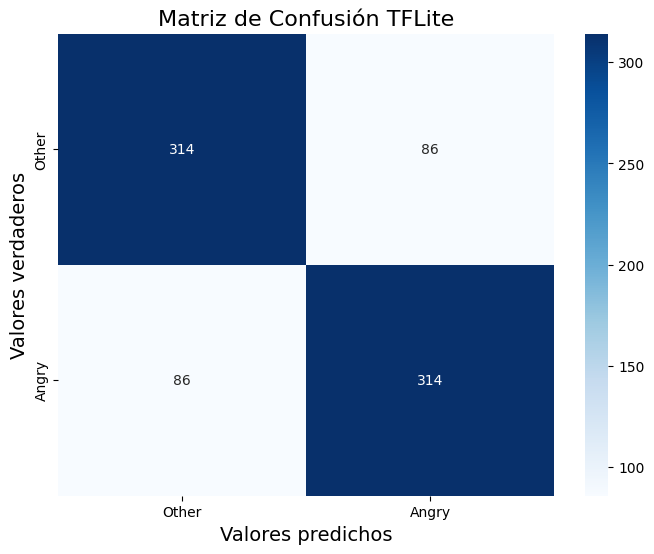

In [55]:
#Predicciones de 0 y 1
predictions_bin = (predictions > umbral).astype(int)

#Vector de clases
clases_vec = [0,1]
emotion_vec = ["Other","Angry"]

#Calcula matriz de confusión
con_mat = confusion_matrix(evalLabels, predictions_bin, labels=clases_vec)
#Convierte matriz en un pandas dataframe
#Rows =    Valores verdaderos
#Columns = Valores predichos
con_mat_df = pd.DataFrame(con_mat, index=emotion_vec, columns=emotion_vec)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión TFLite', fontsize=16)
plt.show()

### Curva ROC

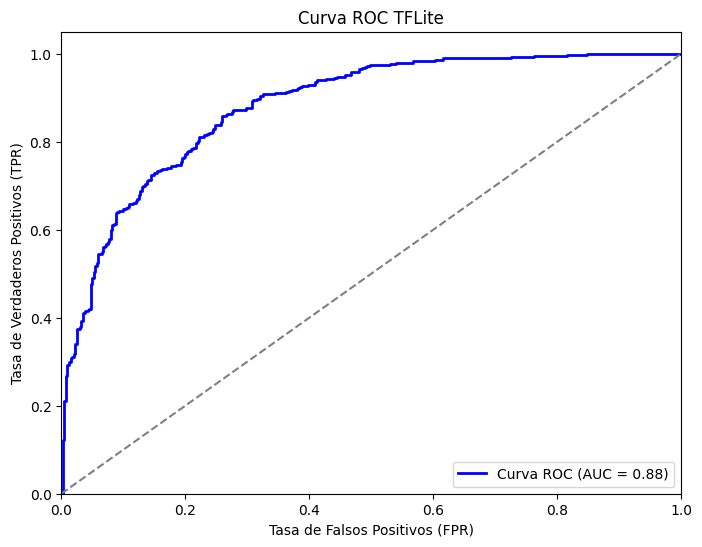

In [56]:
# Supongamos que 'etiquetas_reales' son las etiquetas reales (0 o 1) y 'predicciones' son las predicciones del modelo.
# Asegúrate de tener predicciones continuas (no binarias) en 'predicciones'.

fpr, tpr, umbrales = roc_curve(evalLabels, predictions)
area_bajo_curva = roc_auc_score(evalLabels, predictions)

# Grafica la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {area_bajo_curva:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC TFLite')
plt.legend(loc='lower right')
plt.show()